In [204]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input,Bidirectional,LSTM,Dense,Dropout,Concatenate
import neural_structured_learning as nsl
from tensorflow.keras import regularizers

In [289]:
#Create Data
N = 1000
num_anno = 6

# X = 1-np.random.beta(2,5,N)
# X = np.clip(np.random.normal(0.5,0.145,N),0,1)
X = np.clip(np.concatenate((np.random.normal(0.3,0.1,N//2),np.random.normal(0.7,0.1,N//2))),0,1)
# X = np.clip(((np.random.normal(0.1,0.225,N)+np.random.normal(0.9,0.225,N)))/2,0,1)
# X = np.random.random(N)
# X.sort()
Y = np.empty((N,num_anno))
for i in range(num_anno):
    y = np.random.normal((np.sin(12.5*X)/(np.abs(X)+2)),0.3*np.exp(X*-3)+0.01)
    Y[:,i] = y

Y = Y + np.reshape(np.random.normal(np.zeros(N), 0.3*np.exp((1-X)*-3)),(len(Y),1))

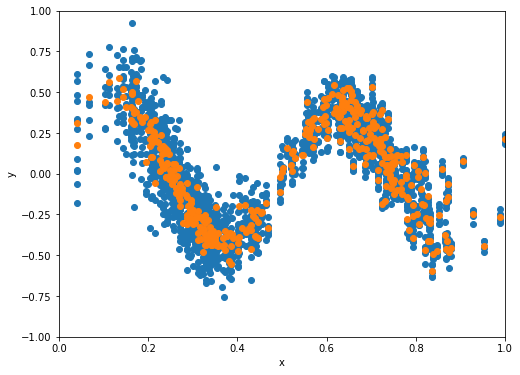

In [285]:
plt.figure(figsize=(8, 6))
plt.scatter(np.outer(X,np.ones(6)),Y)
plt.xlim([0,1])
plt.ylim([-1,1])
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X,np.mean(Y,axis=1))

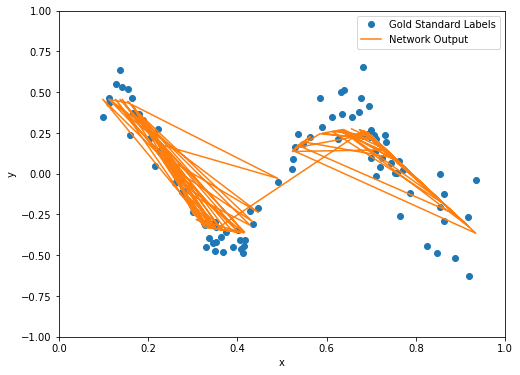

In [133]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, input_dim=1, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

x_train = X.reshape((len(X),1))
y_train = np.reshape(np.mean(Y,1),(len(X),1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=tf.keras.losses.MeanSquaredError())


model.fit(x_train,y_train,verbose=0,epochs=1000, shuffle=True)
y = model.predict(x_train)

plt.figure(figsize=(8, 6))
plt.xlim([0,1])
plt.ylim([-1,1])
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x_train,y_train, 'o', label='Gold Standard Labels')
plt.plot(x_train,y, label='Network Output')
plt.legend()


In [ ]:
# def MCDropout(rate):
#     return tf.keras.layers.Lambda(lambda x: tf.keras.backend.dropout(x, level=rate))

# y = model(np.ones((1000,1)), training=True)

num_points = 1000
num_samples = 1000

x = np.linspace(0,1,num_points)

y_mc = np.empty((num_points,num_samples))

for i in range(num_samples):
    y_mc[:,i] = model(np.reshape(x,(num_points,1)), training=True).numpy().flatten()

mc_u = np.mean(y_mc,1)
mc_s = np.std(y_mc,1)

plt.figure(figsize=(8, 6))
plt.xlim([0,1])
plt.ylim([-1,1])
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x_train,y_train, 'o', label='Gold Standard Labels')
plt.plot(x,mc_u, label='Ensemble Mean')
plt.fill_between(x, mc_u - mc_s, mc_u + mc_s, alpha=0.2, color='tab:orange', label='1 stdev uncertainty')
plt.legend()

# plt.scatter(np.outer(X,np.ones(num_samples)),y_mc)

(1000, 1)
(1000, 6)


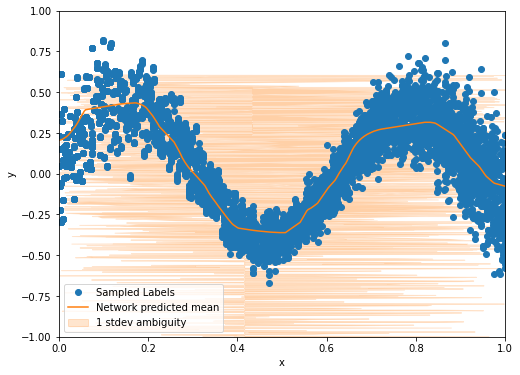

In [263]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Dense(64, input_dim=1, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(2))

x_train = X.reshape((len(X),1))
Y_u = np.mean(Y,1)
Y_s = np.std(Y,1)
y_train = Y

print(x_train.shape)
print(y_train.shape)

def my_nll(y_true,y_pred):
#     print(y_true)
#     print(y_pred)
    y_u = y_pred[:,0]
    y_s = tf.clip_by_value(tf.math.softplus(y_pred[:,1]),clip_value_min=10**(-6),clip_value_max=100000)
    
    C = 1.83 #ln(2pi)
    
#     tf.print(tf.math.log(y_s)+tf.math.divide(tf.math.square(y_true[:,0]-y_u),y_s))
    
    loss = []
    
    for i in range(y_true.shape[1]):
        loss.append(tf.math.log(y_s) + tf.math.divide(tf.math.square(y_true[:,i]-y_u),y_s) + C)
    
    
#     tf.print(tf.reduce_sum(tf.stack(loss),0))
#     for i in loss:
#         print(i[7])
#         tf.print(i)
    
    return tf.math.reduce_sum(tf.stack(loss), 0)/2
1
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=my_nll)


model2.fit(x_train,y_train,verbose=0,epochs=1000, shuffle=True)

x_test = np.reshape(np.linspace(-1,2,n_test),(n_test,1))
y = model2.predict(x_test)

y_u = y[:,0]
y_s = tf.math.sqrt(tf.math.softplus(y[:,1]))

# plt.scatter(np.outer(X,np.ones(num_anno)),Y)
# plt.plot(x_train,y[:,0])
# plt.plot(x_train,y[:,0]+tf.math.softplus(y[:,1]))
# plt.plot(x_train,y[:,0]-tf.math.softplus(y[:,1]))

plt.figure(figsize=(8, 6))
plt.xlim([0,1])
plt.ylim([-1,1])
plt.xlabel('x')
plt.ylabel('y')



plt.plot(np.outer(X,np.ones(num_anno)).flatten(),Y.flatten(), 'o', label='Sampled Labels')
plt.plot(x_test,y_u, label='Network predicted mean')
plt.fill_between(x_train.flatten(), y_u - y_s, y_u + y_s, alpha=0.2, color='tab:orange', label='1 stdev ambiguity')
plt.legend()
# plt.plot(x_train,y)

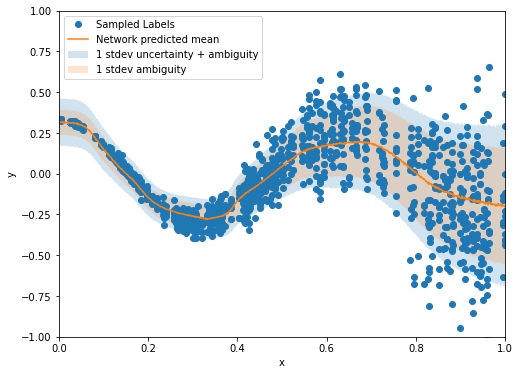

In [7]:
num_points = 1000
num_samples = 1000

y_mc_u = np.empty((num_points,num_samples))
y_mc_s = np.empty((num_points,num_samples))

for i in range(num_samples):
    y_mc_u[:,i] = model2(np.reshape(np.linspace(0,1,num_points),(num_points,1)), training=True).numpy()[:,0]
    y_mc_s[:,i] = model2(np.reshape(np.linspace(0,1,num_points),(num_points,1)), training=True).numpy()[:,1]

mc_u = np.mean(y_mc_u,1)
mc_s = np.sqrt(np.mean(tf.math.softplus(y_mc_s),1))
mc_t = np.std(y_mc_u,1)

# plt.scatter(np.outer(X,np.ones(num_anno)),Y)

# # plt.plot(x_train,y_train[:,0])
# # plt.plot(x_train,y_train[:,0]+y_train[:,1])
# # plt.plot(x_train,y_train[:,0]-y_train[:,1])

# plt.plot(np.linspace(0,1,num_points),mc_u)
# plt.plot(np.linspace(0,1,num_points),mc_u+mc_s+mc_t)
# plt.plot(np.linspace(0,1,num_points),mc_u-mc_s-mc_t)

y_u = mc_u
y_s = mc_s
y_t = mc_t

plt.figure(figsize=(8, 6))
plt.xlim([0,1])
plt.ylim([-1,1])
plt.xlabel('x')
plt.ylabel('y')

plt.plot(np.outer(X,np.ones(num_anno)).flatten(),Y.flatten(), 'o', label='Sampled Labels')
plt.plot(x,y_u, label='Network predicted mean')
plt.fill_between(x, y_u - y_s - y_t, y_u + y_s + y_t, alpha=0.2, label='1 stdev uncertainty + ambiguity')
plt.fill_between(x, y_u - y_s, y_u + y_s, alpha=0.2, label='1 stdev ambiguity')
plt.legend()

In [298]:
def my_NIG_loss(y_true, y_pred):
    #train the model on NLL loss, given the 6 annotations
    #4 parameters of NIG prior
    alpha = y_pred[:,0]
    beta = y_pred[:,1]
    gamma = y_pred[:,2]
    nu = y_pred[:,3]
    
    num_labels = y_true.shape[1]
    y = tf.math.reduce_mean(y_true,axis=1)
    tol = 1/tf.math.reduce_variance(y_true,axis=1)
#     var = tf.math.reduce_variance(y_true,axis=1)
    
#     omega = 2*beta*(1+nu)
#     y_true = y_true[:,:]
    #regularization coefficient
#     rcoeff = 0.1
    
    #calculate nll loss as used in Amini et al.'s DER
#     nll = (0.5*tf.math.log(3.14159/nu) - tf.math.multiply(alpha,tf.math.log(omega))+tf.math.lgamma(alpha)-tf.math.lgamma(alpha+0.5))
#     nll = 0
    
    #component of nll dependent on labels:
#     for n in range(6):
#         y = y_true[:,n]
#         nll += tf.math.multiply((alpha+0.5),tf.math.log(tf.math.multiply(tf.math.square(y-gamma),nu)+omega)/6)
#         nll += rcoeff*tf.math.multiply(tf.math.abs(y-gamma),(2*nu+alpha))
#         nll = 0.5*(tf.math.log(nu) + ((y - gamma) ** 2)/nu + 1.837877)
    
#     nll += 6*(tf.math.lgamma(var) + (alpha+1)*tf.math.log(var) + beta/var -alpha*tf.math.log(beta))

#     nll += tf.math.lgamma(var) + (alpha+1)*tf.math.log(var) + beta/var - alpha*tf.math.log(beta)
#     nll += rcoeff*tf.math.abs((beta/(alpha-1) - var))*(2*alpha+nu)
#     nll += 

    nll = 0.5*(tf.math.log(nu) + tf.math.square(y - gamma)/nu + 1.837877)
#     nll += 5*(y - gamma)**2
#     nll += 7*nu
    nll += (beta*tol + tf.math.lgamma(alpha) - (alpha-1)*tf.math.log(tol) - alpha*tf.math.log(beta))
    
    return nll

def my_dual_nll_loss(y_true, y_pred):
    
    mu = y_pred[:,0]
    sigma2 = y_pred[:,1]
    alpha = y_pred[:,2]
    beta = y_pred[:,3]
    
    num_labels = y_true.shape[1]
    y = tf.math.reduce_mean(y_true,axis=1) #annotation mean
    tol = 1/tf.math.reduce_variance(y_true,axis=1) #tolerance = 1/variance
    Vamb = (beta/(alpha-1))/num_labels
    
    nll = 0.5*(tf.math.log(sigma2+Vamb) + ((y - mu) ** 2)/(sigma2+Vamb) + 1.837877) #fit mean
    nll += beta*tol + tf.math.lgamma(alpha) - (alpha-1)*tf.math.log(tol) - alpha*tf.math.log(beta) #fit amb
    
    return nll

x_train = X.reshape((len(X),1))
y_train = Y

models = []
# du_models = []
# mu_models = []
# amb_models = []
num_models = 5
rcoeff = 0.001
for i in range(num_models):
    inputs = Input(shape=(1,))
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(rcoeff))(inputs)
    x = Dropout(0.1)(x)#, training=True)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(rcoeff))(x)
    x = Dropout(0.1)(x)#, training=True)
    mu = Dense(1, activation="tanh")(x)
    sigma2 = Dense(1, activation="softplus")(x)
    alpha = Dense(1, activation="softplus")(x)
    beta = Dense(1, activation="softplus")(x)
    outputs = Concatenate()([mu, sigma2 , alpha+1, beta]) #4 parameters of NIG distribution

    model_nll = keras.Model(inputs, outputs)
    model_nll.summary()

    #train model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model_nll.compile(optimizer=optimizer, loss=my_dual_nll_loss)
    
#     adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.01)
#     adv_model = nsl.keras.AdversarialRegularization(model_NIG, adv_config)
#     adv_model.compile(optimizer=optimizer, loss=my_NIG_loss)
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, verbose=0, mode='min', min_delta=0.0001, restore_best_weights=True)
    
    model_nll.fit(x_train,y_train, batch_size=5, epochs=10000, validation_split=0.1, shuffle=True, callbacks=[early_stopping])
    models.append(model_nll)


Model: "model_165"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_167 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_996 (Dense)               (None, 64)           128         input_167[0][0]                  
__________________________________________________________________________________________________
dropout_334 (Dropout)           (None, 64)           0           dense_996[0][0]                  
__________________________________________________________________________________________________
dense_997 (Dense)               (None, 64)           4160        dropout_334[0][0]                
__________________________________________________________________________________________

180/180 [==============================] - 0s 660us/step - loss: 6.5003 - val_loss: 7.4834
Epoch 128/10000
180/180 [==============================] - 0s 693us/step - loss: 6.4547 - val_loss: 7.5331
Epoch 129/10000
180/180 [==============================] - 0s 664us/step - loss: 6.5197 - val_loss: 7.4561
Epoch 130/10000
180/180 [==============================] - 0s 660us/step - loss: 6.5884 - val_loss: 7.3490
Epoch 131/10000
180/180 [==============================] - 0s 671us/step - loss: 6.6004 - val_loss: 7.4719
Epoch 132/10000
180/180 [==============================] - 0s 653us/step - loss: 6.3877 - val_loss: 7.4410
Epoch 133/10000
180/180 [==============================] - 0s 665us/step - loss: 6.5153 - val_loss: 7.5211
Epoch 134/10000
180/180 [==============================] - 0s 654us/step - loss: 6.4525 - val_loss: 7.4983
Epoch 135/10000
180/180 [==============================] - 0s 665us/step - loss: 6.4399 - val_loss: 7.8854
Epoch 136/10000
180/180 [============================

180/180 [==============================] - 0s 688us/step - loss: 6.2435 - val_loss: 7.2538
Epoch 280/10000
180/180 [==============================] - 0s 677us/step - loss: 6.2222 - val_loss: 7.2407
Epoch 281/10000
180/180 [==============================] - 0s 710us/step - loss: 6.2524 - val_loss: 7.3371
Epoch 282/10000
180/180 [==============================] - 0s 654us/step - loss: 6.2507 - val_loss: 7.2599
Epoch 283/10000
180/180 [==============================] - 0s 654us/step - loss: 6.2879 - val_loss: 7.3012
Epoch 284/10000
180/180 [==============================] - 0s 688us/step - loss: 6.2369 - val_loss: 7.3082
Epoch 285/10000
180/180 [==============================] - 0s 643us/step - loss: 6.2891 - val_loss: 7.4066
Epoch 286/10000
180/180 [==============================] - 0s 688us/step - loss: 6.3163 - val_loss: 7.5781
Epoch 287/10000
180/180 [==============================] - 0s 665us/step - loss: 6.2470 - val_loss: 7.3165
Epoch 288/10000
180/180 [============================

180/180 [==============================] - 0s 671us/step - loss: 6.1952 - val_loss: 7.2321
Epoch 432/10000
180/180 [==============================] - 0s 660us/step - loss: 6.2101 - val_loss: 7.1934
Epoch 433/10000
180/180 [==============================] - 0s 665us/step - loss: 6.1870 - val_loss: 7.1783
Epoch 434/10000
180/180 [==============================] - 0s 660us/step - loss: 6.1989 - val_loss: 7.4202
Epoch 435/10000
180/180 [==============================] - 0s 688us/step - loss: 6.2282 - val_loss: 7.1983
Epoch 436/10000
180/180 [==============================] - 0s 689us/step - loss: 6.1802 - val_loss: 7.2766
Epoch 437/10000
180/180 [==============================] - 0s 665us/step - loss: 6.2438 - val_loss: 7.2221
Epoch 438/10000
180/180 [==============================] - 0s 671us/step - loss: 6.1445 - val_loss: 7.1659
Epoch 439/10000
180/180 [==============================] - 0s 654us/step - loss: 6.1639 - val_loss: 7.2114
Epoch 440/10000
180/180 [============================

180/180 [==============================] - 0s 671us/step - loss: 6.1224 - val_loss: 7.1967
Epoch 584/10000
180/180 [==============================] - 0s 654us/step - loss: 6.1494 - val_loss: 7.2274
Epoch 585/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1257 - val_loss: 7.2116
Epoch 586/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1253 - val_loss: 7.2740
Epoch 587/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1198 - val_loss: 7.2060
Epoch 588/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1473 - val_loss: 7.1132
Epoch 589/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1363 - val_loss: 7.1562
Epoch 590/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0990 - val_loss: 7.1524
Epoch 591/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0655 - val_loss: 7.1425
Epoch 592/10000
180/180 [============================

180/180 [==============================] - 0s 692us/step - loss: 5.9995 - val_loss: 7.0741
Epoch 736/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0324 - val_loss: 7.2215
Epoch 737/10000
180/180 [==============================] - 0s 661us/step - loss: 6.0498 - val_loss: 7.1518
Epoch 738/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0719 - val_loss: 7.0908
Epoch 739/10000
180/180 [==============================] - 0s 668us/step - loss: 6.0854 - val_loss: 7.2539
Epoch 740/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0650 - val_loss: 7.1523
Epoch 741/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0705 - val_loss: 7.1284
Epoch 742/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0914 - val_loss: 7.1646
Epoch 743/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0599 - val_loss: 7.1869
Epoch 744/10000
180/180 [============================

180/180 [==============================] - 0s 682us/step - loss: 6.0170 - val_loss: 7.1154
Epoch 888/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0585 - val_loss: 7.1460
Epoch 889/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0349 - val_loss: 7.1597
Epoch 890/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0469 - val_loss: 7.1338
Epoch 891/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0519 - val_loss: 7.1347
Epoch 892/10000
180/180 [==============================] - 0s 677us/step - loss: 6.0617 - val_loss: 7.2078
Epoch 893/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0305 - val_loss: 7.1204
Epoch 894/10000
180/180 [==============================] - 0s 677us/step - loss: 6.0451 - val_loss: 7.1232
Epoch 895/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0102 - val_loss: 7.1319
Epoch 896/10000
180/180 [============================

180/180 [==============================] - 0s 677us/step - loss: 6.0391 - val_loss: 7.3948
Epoch 1040/10000
180/180 [==============================] - 0s 664us/step - loss: 6.0028 - val_loss: 7.1054
Epoch 1041/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0618 - val_loss: 7.1357
Epoch 1042/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9992 - val_loss: 7.0663
Epoch 1043/10000
180/180 [==============================] - 0s 670us/step - loss: 6.0090 - val_loss: 7.1976
Epoch 1044/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0441 - val_loss: 7.0831
Epoch 1045/10000
180/180 [==============================] - 0s 649us/step - loss: 5.9615 - val_loss: 7.0477
Epoch 1046/10000
180/180 [==============================] - 0s 647us/step - loss: 5.9953 - val_loss: 7.0556
Epoch 1047/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0202 - val_loss: 7.0431
Epoch 1048/10000
180/180 [===================

180/180 [==============================] - 0s 677us/step - loss: 5.9740 - val_loss: 7.1052
Epoch 1116/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0250 - val_loss: 7.0469
Epoch 1117/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0163 - val_loss: 7.2308
Epoch 1118/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9878 - val_loss: 7.0936
Epoch 1119/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0119 - val_loss: 7.0687
Epoch 1120/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9991 - val_loss: 7.2677
Epoch 1121/10000
180/180 [==============================] - 0s 682us/step - loss: 5.9960 - val_loss: 7.1242
Epoch 1122/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0116 - val_loss: 7.0747
Epoch 1123/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0265 - val_loss: 7.0958
Epoch 1124/10000
180/180 [===================

180/180 [==============================] - 0s 665us/step - loss: 5.9726 - val_loss: 7.1189
Epoch 1192/10000
180/180 [==============================] - 0s 654us/step - loss: 5.9795 - val_loss: 7.1963
Epoch 1193/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9718 - val_loss: 7.1550
Epoch 1194/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9805 - val_loss: 7.1416
Epoch 1195/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9867 - val_loss: 7.0579
Epoch 1196/10000
180/180 [==============================] - 0s 688us/step - loss: 5.9775 - val_loss: 7.0790
Epoch 1197/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0187 - val_loss: 7.0551
Epoch 1198/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9793 - val_loss: 7.1106
Epoch 1199/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0273 - val_loss: 7.2190
Epoch 1200/10000
180/180 [===================

180/180 [==============================] - 0s 688us/step - loss: 5.9843 - val_loss: 7.0742
Epoch 1268/10000
180/180 [==============================] - 0s 677us/step - loss: 6.0029 - val_loss: 7.1030
Epoch 1269/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9578 - val_loss: 7.1425
Epoch 1270/10000
180/180 [==============================] - 0s 677us/step - loss: 6.0024 - val_loss: 7.1577
Epoch 1271/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0067 - val_loss: 7.0758
Epoch 1272/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9843 - val_loss: 7.0819
Epoch 1273/10000
180/180 [==============================] - 0s 654us/step - loss: 6.0075 - val_loss: 7.1451
Epoch 1274/10000
180/180 [==============================] - 0s 654us/step - loss: 6.0181 - val_loss: 7.0416
Epoch 1275/10000
180/180 [==============================] - 0s 654us/step - loss: 5.9756 - val_loss: 7.2093
Epoch 1276/10000
180/180 [===================

180/180 [==============================] - 0s 671us/step - loss: 6.0015 - val_loss: 7.0576
Epoch 1344/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9200 - val_loss: 7.0681
Epoch 1345/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9625 - val_loss: 7.0609
Epoch 1346/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9733 - val_loss: 7.0494
Epoch 1347/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9867 - val_loss: 7.0740
Epoch 1348/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9727 - val_loss: 7.0522
Epoch 1349/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9549 - val_loss: 7.1125
Epoch 1350/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9547 - val_loss: 7.0738
Epoch 1351/10000
180/180 [==============================] - 0s 682us/step - loss: 5.9489 - val_loss: 7.0857
Epoch 1352/10000
180/180 [===================

180/180 [==============================] - 0s 676us/step - loss: 5.9521 - val_loss: 7.0321
Epoch 1420/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9442 - val_loss: 7.2024
Epoch 1421/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9721 - val_loss: 7.1165
Epoch 1422/10000
180/180 [==============================] - 0s 674us/step - loss: 5.9652 - val_loss: 7.0733
Epoch 1423/10000
180/180 [==============================] - 0s 710us/step - loss: 5.9930 - val_loss: 7.0713
Epoch 1424/10000
180/180 [==============================] - 0s 699us/step - loss: 5.9777 - val_loss: 7.2113
Epoch 1425/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9386 - val_loss: 7.0862
Epoch 1426/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9476 - val_loss: 7.0964
Epoch 1427/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9636 - val_loss: 7.0725
Epoch 1428/10000
180/180 [===================

180/180 [==============================] - 0s 665us/step - loss: 5.9393 - val_loss: 7.1212
Epoch 1496/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9474 - val_loss: 7.0934
Epoch 1497/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9758 - val_loss: 7.0826
Epoch 1498/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9708 - val_loss: 7.1895
Epoch 1499/10000
180/180 [==============================] - 0s 693us/step - loss: 5.9583 - val_loss: 7.0251
Epoch 1500/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9444 - val_loss: 7.0719
Epoch 1501/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9586 - val_loss: 7.2444
Epoch 1502/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9660 - val_loss: 7.0697
Epoch 1503/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9577 - val_loss: 7.0704
Epoch 1504/10000
180/180 [===================

180/180 [==============================] - 0s 677us/step - loss: 6.0120 - val_loss: 7.0788
Epoch 1572/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9765 - val_loss: 7.0489
Epoch 1573/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9422 - val_loss: 7.0548
Epoch 1574/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9108 - val_loss: 7.0246
Epoch 1575/10000
180/180 [==============================] - 0s 682us/step - loss: 5.9758 - val_loss: 7.1184
Epoch 1576/10000
180/180 [==============================] - 0s 688us/step - loss: 5.9477 - val_loss: 7.1466
Epoch 1577/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9468 - val_loss: 7.1585
Epoch 1578/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9742 - val_loss: 7.1194
Epoch 1579/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0029 - val_loss: 7.0729
Epoch 1580/10000
180/180 [===================

180/180 [==============================] - 0s 671us/step - loss: 5.9296 - val_loss: 7.0280
Epoch 1648/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9636 - val_loss: 7.0905
Epoch 1649/10000
180/180 [==============================] - 0s 643us/step - loss: 5.9443 - val_loss: 7.0060
Epoch 1650/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9630 - val_loss: 7.1136
Epoch 1651/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9356 - val_loss: 7.0257
Epoch 1652/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9622 - val_loss: 7.0438
Epoch 1653/10000
180/180 [==============================] - 0s 664us/step - loss: 5.9555 - val_loss: 7.0662
Epoch 1654/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9702 - val_loss: 7.1020
Epoch 1655/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9474 - val_loss: 7.1082
Epoch 1656/10000
180/180 [===================

180/180 [==============================] - 0s 677us/step - loss: 5.9652 - val_loss: 7.0569
Epoch 1724/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9337 - val_loss: 7.0424
Epoch 1725/10000
180/180 [==============================] - 0s 688us/step - loss: 5.9187 - val_loss: 7.0482
Epoch 1726/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9442 - val_loss: 7.1421
Epoch 1727/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9688 - val_loss: 7.2331
Epoch 1728/10000
180/180 [==============================] - 0s 682us/step - loss: 5.9561 - val_loss: 7.1221
Epoch 1729/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9584 - val_loss: 7.0710
Epoch 1730/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9310 - val_loss: 7.1388
Epoch 1731/10000
180/180 [==============================] - 0s 643us/step - loss: 5.9561 - val_loss: 7.0548
Epoch 1732/10000
180/180 [===================

180/180 [==============================] - 0s 665us/step - loss: 5.8948 - val_loss: 7.0952
Epoch 1800/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0028 - val_loss: 7.1294
Epoch 1801/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9343 - val_loss: 7.0333
Epoch 1802/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9542 - val_loss: 7.0875
Epoch 1803/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9642 - val_loss: 7.0296
Epoch 1804/10000
180/180 [==============================] - 0s 654us/step - loss: 5.9497 - val_loss: 7.0442
Epoch 1805/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9477 - val_loss: 7.1148
Epoch 1806/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9714 - val_loss: 7.0743
Epoch 1807/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9599 - val_loss: 7.0282
Epoch 1808/10000
180/180 [===================

180/180 [==============================] - 0s 677us/step - loss: 5.9221 - val_loss: 7.0517
Epoch 1876/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9580 - val_loss: 7.0739
Epoch 1877/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9512 - val_loss: 7.1292
Epoch 1878/10000
180/180 [==============================] - 0s 658us/step - loss: 5.9677 - val_loss: 7.0696
Epoch 1879/10000
180/180 [==============================] - 0s 649us/step - loss: 5.9576 - val_loss: 7.0408
Epoch 1880/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9397 - val_loss: 7.0199
Epoch 1881/10000
180/180 [==============================] - 0s 676us/step - loss: 5.9730 - val_loss: 7.0465
Epoch 1882/10000
180/180 [==============================] - 0s 671us/step - loss: 5.9378 - val_loss: 7.0155
Epoch 1883/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9106 - val_loss: 7.1239
Epoch 1884/10000
180/180 [===================

180/180 [==============================] - 0s 665us/step - loss: 5.9608 - val_loss: 7.0523
Epoch 1952/10000
180/180 [==============================] - 0s 660us/step - loss: 5.9537 - val_loss: 7.0990
Epoch 1953/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9078 - val_loss: 7.0245
Epoch 1954/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9267 - val_loss: 7.2102
Epoch 1955/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9186 - val_loss: 7.0657
Epoch 1956/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9526 - val_loss: 7.0398
Epoch 1957/10000
180/180 [==============================] - 0s 688us/step - loss: 5.9312 - val_loss: 7.0344
Epoch 1958/10000
180/180 [==============================] - 0s 693us/step - loss: 5.9738 - val_loss: 7.0462
Epoch 1959/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0043 - val_loss: 7.1186
Epoch 1960/10000
180/180 [===================

180/180 [==============================] - 0s 626us/step - loss: 6.3703 - val_loss: 7.4432
Epoch 111/10000
180/180 [==============================] - 0s 631us/step - loss: 6.3745 - val_loss: 7.3673
Epoch 112/10000
180/180 [==============================] - 0s 626us/step - loss: 6.3771 - val_loss: 7.4196
Epoch 113/10000
180/180 [==============================] - 0s 630us/step - loss: 6.4056 - val_loss: 7.2967
Epoch 114/10000
180/180 [==============================] - 0s 626us/step - loss: 6.4331 - val_loss: 7.3763
Epoch 115/10000
180/180 [==============================] - 0s 632us/step - loss: 6.4187 - val_loss: 7.3561
Epoch 116/10000
180/180 [==============================] - 0s 643us/step - loss: 6.3715 - val_loss: 7.3712
Epoch 117/10000
180/180 [==============================] - 0s 632us/step - loss: 6.4244 - val_loss: 7.3688
Epoch 118/10000
180/180 [==============================] - 0s 626us/step - loss: 6.4028 - val_loss: 7.3886
Epoch 119/10000
180/180 [============================

180/180 [==============================] - 0s 649us/step - loss: 6.2157 - val_loss: 7.1115
Epoch 263/10000
180/180 [==============================] - 0s 643us/step - loss: 6.2089 - val_loss: 7.2363
Epoch 264/10000
180/180 [==============================] - 0s 677us/step - loss: 6.1558 - val_loss: 7.1369
Epoch 265/10000
180/180 [==============================] - 0s 649us/step - loss: 6.1965 - val_loss: 7.1175
Epoch 266/10000
180/180 [==============================] - 0s 632us/step - loss: 6.2067 - val_loss: 7.1718
Epoch 267/10000
180/180 [==============================] - 0s 682us/step - loss: 6.2396 - val_loss: 7.2053
Epoch 268/10000
180/180 [==============================] - 0s 665us/step - loss: 6.1919 - val_loss: 7.1679
Epoch 269/10000
180/180 [==============================] - 0s 682us/step - loss: 6.1980 - val_loss: 7.1629
Epoch 270/10000
180/180 [==============================] - 0s 660us/step - loss: 6.1217 - val_loss: 7.1664
Epoch 271/10000
180/180 [============================

180/180 [==============================] - 0s 637us/step - loss: 6.1386 - val_loss: 7.2067
Epoch 415/10000
180/180 [==============================] - 0s 626us/step - loss: 6.1346 - val_loss: 7.1334
Epoch 416/10000
180/180 [==============================] - 0s 665us/step - loss: 6.1220 - val_loss: 7.1146
Epoch 417/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1523 - val_loss: 7.1902
Epoch 418/10000
180/180 [==============================] - 0s 621us/step - loss: 6.1779 - val_loss: 7.1603
Epoch 419/10000
180/180 [==============================] - 0s 621us/step - loss: 6.1367 - val_loss: 7.2099
Epoch 420/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0860 - val_loss: 7.1065
Epoch 421/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1151 - val_loss: 7.0870
Epoch 422/10000
180/180 [==============================] - 0s 626us/step - loss: 6.1438 - val_loss: 7.2442
Epoch 423/10000
180/180 [============================

180/180 [==============================] - 0s 660us/step - loss: 6.0510 - val_loss: 7.1175
Epoch 567/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0487 - val_loss: 7.0566
Epoch 568/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0872 - val_loss: 7.1468
Epoch 569/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0972 - val_loss: 7.0607
Epoch 570/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0737 - val_loss: 7.2168
Epoch 571/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0573 - val_loss: 7.1139
Epoch 572/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0642 - val_loss: 7.0780
Epoch 573/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0878 - val_loss: 7.2308
Epoch 574/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0727 - val_loss: 7.1155
Epoch 575/10000
180/180 [============================

180/180 [==============================] - 0s 649us/step - loss: 6.0656 - val_loss: 7.1553
Epoch 719/10000
180/180 [==============================] - 0s 637us/step - loss: 5.9902 - val_loss: 7.1016
Epoch 720/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0068 - val_loss: 7.1616
Epoch 721/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0284 - val_loss: 7.1173
Epoch 722/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0501 - val_loss: 7.0565
Epoch 723/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0468 - val_loss: 7.0605
Epoch 724/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0305 - val_loss: 7.1164
Epoch 725/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0633 - val_loss: 7.1341
Epoch 726/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0834 - val_loss: 7.2431
Epoch 727/10000
180/180 [============================

180/180 [==============================] - 1s 1ms/step - loss: 59.4975 - val_loss: 7.9777
Epoch 2/10000
180/180 [==============================] - 0s 643us/step - loss: 7.6675 - val_loss: 7.9355
Epoch 3/10000
180/180 [==============================] - 0s 643us/step - loss: 7.5805 - val_loss: 7.9222
Epoch 4/10000
180/180 [==============================] - 0s 637us/step - loss: 7.3481 - val_loss: 7.8703
Epoch 5/10000
180/180 [==============================] - 0s 637us/step - loss: 7.3209 - val_loss: 7.9512
Epoch 6/10000
180/180 [==============================] - 0s 643us/step - loss: 7.2670 - val_loss: 7.9078
Epoch 7/10000
180/180 [==============================] - 0s 649us/step - loss: 7.2335 - val_loss: 7.9706
Epoch 8/10000
180/180 [==============================] - 0s 660us/step - loss: 7.2259 - val_loss: 7.9177
Epoch 9/10000
180/180 [==============================] - 0s 649us/step - loss: 7.2537 - val_loss: 7.9184
Epoch 10/10000
180/180 [==============================] - 0s 643us/ste

Epoch 155/10000
180/180 [==============================] - 0s 660us/step - loss: 7.0016 - val_loss: 7.8715
Epoch 156/10000
180/180 [==============================] - 0s 665us/step - loss: 7.0302 - val_loss: 7.8895
Epoch 157/10000
180/180 [==============================] - 0s 693us/step - loss: 6.9944 - val_loss: 7.8667
Epoch 158/10000
180/180 [==============================] - 0s 654us/step - loss: 7.0299 - val_loss: 7.8894
Epoch 159/10000
180/180 [==============================] - 0s 649us/step - loss: 6.9667 - val_loss: 7.8679
Epoch 160/10000
180/180 [==============================] - 0s 643us/step - loss: 7.0033 - val_loss: 7.8860
Epoch 161/10000
180/180 [==============================] - 0s 643us/step - loss: 6.9756 - val_loss: 7.8583
Epoch 162/10000
180/180 [==============================] - 0s 649us/step - loss: 7.0593 - val_loss: 7.8724
Epoch 163/10000
180/180 [==============================] - 0s 643us/step - loss: 6.9790 - val_loss: 7.9220
Epoch 164/10000
180/180 [============

180/180 [==============================] - 0s 643us/step - loss: 6.2110 - val_loss: 7.2331
Epoch 308/10000
180/180 [==============================] - 0s 660us/step - loss: 6.1865 - val_loss: 7.2216
Epoch 309/10000
180/180 [==============================] - 0s 643us/step - loss: 6.1558 - val_loss: 7.2227
Epoch 310/10000
180/180 [==============================] - 0s 637us/step - loss: 6.2028 - val_loss: 7.2096
Epoch 311/10000
180/180 [==============================] - 0s 660us/step - loss: 6.1948 - val_loss: 7.2975
Epoch 312/10000
180/180 [==============================] - 0s 671us/step - loss: 6.1801 - val_loss: 7.2140
Epoch 313/10000
180/180 [==============================] - 0s 671us/step - loss: 6.1777 - val_loss: 7.2850
Epoch 314/10000
180/180 [==============================] - 0s 632us/step - loss: 6.2389 - val_loss: 7.2104
Epoch 315/10000
180/180 [==============================] - 0s 660us/step - loss: 6.1720 - val_loss: 7.2456
Epoch 316/10000
180/180 [============================

180/180 [==============================] - 0s 660us/step - loss: 6.1166 - val_loss: 7.3891
Epoch 460/10000
180/180 [==============================] - 0s 664us/step - loss: 6.1333 - val_loss: 7.1905
Epoch 461/10000
180/180 [==============================] - 0s 661us/step - loss: 6.1904 - val_loss: 7.1743
Epoch 462/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1426 - val_loss: 7.3057
Epoch 463/10000
180/180 [==============================] - 0s 626us/step - loss: 6.1365 - val_loss: 7.2604
Epoch 464/10000
180/180 [==============================] - 0s 622us/step - loss: 6.2051 - val_loss: 7.2182
Epoch 465/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1561 - val_loss: 7.2035
Epoch 466/10000
180/180 [==============================] - 0s 671us/step - loss: 6.1433 - val_loss: 7.2787
Epoch 467/10000
180/180 [==============================] - 0s 660us/step - loss: 6.1099 - val_loss: 7.2314
Epoch 468/10000
180/180 [============================

180/180 [==============================] - 0s 649us/step - loss: 6.0415 - val_loss: 7.1818
Epoch 612/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0831 - val_loss: 7.1194
Epoch 613/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0182 - val_loss: 7.1459
Epoch 614/10000
180/180 [==============================] - 0s 654us/step - loss: 6.0922 - val_loss: 7.1837
Epoch 615/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0742 - val_loss: 7.0977
Epoch 616/10000
180/180 [==============================] - 0s 621us/step - loss: 6.0498 - val_loss: 7.0920
Epoch 617/10000
180/180 [==============================] - 0s 643us/step - loss: 6.1084 - val_loss: 7.2093
Epoch 618/10000
180/180 [==============================] - 0s 654us/step - loss: 6.0984 - val_loss: 7.2091
Epoch 619/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0984 - val_loss: 7.2572
Epoch 620/10000
180/180 [============================

180/180 [==============================] - 0s 621us/step - loss: 6.0331 - val_loss: 7.2257
Epoch 764/10000
180/180 [==============================] - 0s 642us/step - loss: 6.0983 - val_loss: 7.1408
Epoch 765/10000
180/180 [==============================] - 0s 625us/step - loss: 6.0834 - val_loss: 7.1387
Epoch 766/10000
180/180 [==============================] - 0s 630us/step - loss: 6.0286 - val_loss: 7.1079
Epoch 767/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1482 - val_loss: 7.1717
Epoch 768/10000
180/180 [==============================] - 0s 621us/step - loss: 6.0841 - val_loss: 7.1444
Epoch 769/10000
180/180 [==============================] - 0s 626us/step - loss: 6.1228 - val_loss: 7.1558
Epoch 770/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0730 - val_loss: 7.1164
Epoch 771/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0175 - val_loss: 7.1016
Epoch 772/10000
180/180 [============================

180/180 [==============================] - 0s 682us/step - loss: 6.0495 - val_loss: 7.0757
Epoch 916/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0108 - val_loss: 7.2573
Epoch 917/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0513 - val_loss: 7.0925
Epoch 918/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0218 - val_loss: 7.2163
Epoch 919/10000
180/180 [==============================] - 0s 699us/step - loss: 6.0491 - val_loss: 7.1967
Epoch 920/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0497 - val_loss: 7.1864
Epoch 921/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0792 - val_loss: 7.0820
Epoch 922/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0812 - val_loss: 7.0852
Epoch 923/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0306 - val_loss: 7.1245
Epoch 924/10000
180/180 [============================

180/180 [==============================] - 0s 716us/step - loss: 6.0325 - val_loss: 7.0580
Epoch 1068/10000
180/180 [==============================] - 0s 766us/step - loss: 6.0317 - val_loss: 7.1310
Epoch 1069/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0232 - val_loss: 7.1094
Epoch 1070/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0633 - val_loss: 7.2048
Epoch 1071/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0792 - val_loss: 7.0684
Epoch 1072/10000
180/180 [==============================] - 0s 632us/step - loss: 5.9637 - val_loss: 7.0524
Epoch 1073/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0318 - val_loss: 7.0723
Epoch 1074/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0472 - val_loss: 7.1294
Epoch 1075/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0301 - val_loss: 7.1614
Epoch 1076/10000
180/180 [===================

180/180 [==============================] - 0s 733us/step - loss: 6.0417 - val_loss: 7.0837
Epoch 1144/10000
180/180 [==============================] - 0s 710us/step - loss: 6.0425 - val_loss: 7.1079
Epoch 1145/10000
180/180 [==============================] - 0s 677us/step - loss: 6.0081 - val_loss: 7.2382
Epoch 1146/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0095 - val_loss: 7.0878
Epoch 1147/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0641 - val_loss: 7.1319
Epoch 1148/10000
180/180 [==============================] - 0s 641us/step - loss: 6.0128 - val_loss: 7.1029
Epoch 1149/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0000 - val_loss: 7.1327
Epoch 1150/10000
180/180 [==============================] - 0s 643us/step - loss: 5.9880 - val_loss: 7.1494
Epoch 1151/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0310 - val_loss: 7.2377
Epoch 1152/10000
180/180 [===================

180/180 [==============================] - 0s 632us/step - loss: 6.0417 - val_loss: 7.1576
Epoch 1220/10000
180/180 [==============================] - 0s 654us/step - loss: 6.0573 - val_loss: 7.2528
Epoch 1221/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0301 - val_loss: 7.0703
Epoch 1222/10000
180/180 [==============================] - 0s 727us/step - loss: 5.9692 - val_loss: 7.0496
Epoch 1223/10000
180/180 [==============================] - 0s 727us/step - loss: 6.0088 - val_loss: 7.1600
Epoch 1224/10000
180/180 [==============================] - 0s 772us/step - loss: 6.0568 - val_loss: 7.2043
Epoch 1225/10000
180/180 [==============================] - 0s 727us/step - loss: 6.0136 - val_loss: 7.0850
Epoch 1226/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0168 - val_loss: 7.2181
Epoch 1227/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0495 - val_loss: 7.0890
Epoch 1228/10000
180/180 [===================

180/180 [==============================] - 0s 671us/step - loss: 6.0220 - val_loss: 7.1011
Epoch 1296/10000
180/180 [==============================] - 0s 733us/step - loss: 5.9841 - val_loss: 7.2038
Epoch 1297/10000
180/180 [==============================] - 0s 677us/step - loss: 5.9950 - val_loss: 7.0988
Epoch 1298/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0137 - val_loss: 7.0836
Epoch 1299/10000
180/180 [==============================] - 0s 721us/step - loss: 6.0073 - val_loss: 7.0599
Epoch 1300/10000
180/180 [==============================] - 0s 649us/step - loss: 5.9964 - val_loss: 7.2075
Epoch 1301/10000
180/180 [==============================] - 0s 699us/step - loss: 5.9896 - val_loss: 7.0441
Epoch 1302/10000
180/180 [==============================] - 0s 693us/step - loss: 5.9981 - val_loss: 7.0440
Epoch 1303/10000
180/180 [==============================] - 0s 693us/step - loss: 5.9609 - val_loss: 7.0546
Epoch 1304/10000
180/180 [===================

180/180 [==============================] - 0s 643us/step - loss: 6.0467 - val_loss: 7.2176
Epoch 1372/10000
180/180 [==============================] - 0s 643us/step - loss: 5.9931 - val_loss: 7.0804
Epoch 1373/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0011 - val_loss: 7.0588
Epoch 1374/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0195 - val_loss: 7.0643
Epoch 1375/10000
180/180 [==============================] - 0s 637us/step - loss: 5.9601 - val_loss: 7.0784
Epoch 1376/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0119 - val_loss: 7.0953
Epoch 1377/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9793 - val_loss: 7.0970
Epoch 1378/10000
180/180 [==============================] - 0s 665us/step - loss: 5.9812 - val_loss: 7.1024
Epoch 1379/10000
180/180 [==============================] - 0s 649us/step - loss: 5.9781 - val_loss: 7.0943
Epoch 1380/10000
180/180 [===================

Epoch 35/10000
180/180 [==============================] - 0s 643us/step - loss: 7.0661 - val_loss: 8.0291
Epoch 36/10000
180/180 [==============================] - 0s 654us/step - loss: 7.1123 - val_loss: 7.9607
Epoch 37/10000
180/180 [==============================] - 0s 665us/step - loss: 7.0600 - val_loss: 7.8960
Epoch 38/10000
180/180 [==============================] - 0s 654us/step - loss: 7.0867 - val_loss: 8.0027
Epoch 39/10000
180/180 [==============================] - 0s 643us/step - loss: 7.1046 - val_loss: 7.9588
Epoch 40/10000
180/180 [==============================] - 0s 626us/step - loss: 7.0624 - val_loss: 7.8911
Epoch 41/10000
180/180 [==============================] - 0s 643us/step - loss: 7.0295 - val_loss: 7.9162
Epoch 42/10000
180/180 [==============================] - 0s 660us/step - loss: 7.0526 - val_loss: 7.9769
Epoch 43/10000
180/180 [==============================] - 0s 660us/step - loss: 7.0154 - val_loss: 7.9845
Epoch 44/10000
180/180 [======================

180/180 [==============================] - 0s 654us/step - loss: 6.2974 - val_loss: 7.3445
Epoch 189/10000
180/180 [==============================] - 0s 643us/step - loss: 6.2658 - val_loss: 7.3502
Epoch 190/10000
180/180 [==============================] - 0s 637us/step - loss: 6.3151 - val_loss: 7.3303
Epoch 191/10000
180/180 [==============================] - 0s 637us/step - loss: 6.2812 - val_loss: 7.3282
Epoch 192/10000
180/180 [==============================] - 0s 649us/step - loss: 6.3466 - val_loss: 7.4164
Epoch 193/10000
180/180 [==============================] - 0s 643us/step - loss: 6.2904 - val_loss: 7.3761
Epoch 194/10000
180/180 [==============================] - 0s 643us/step - loss: 6.3010 - val_loss: 7.3661
Epoch 195/10000
180/180 [==============================] - 0s 637us/step - loss: 6.3089 - val_loss: 7.3677
Epoch 196/10000
180/180 [==============================] - 0s 649us/step - loss: 6.2445 - val_loss: 7.3165
Epoch 197/10000
180/180 [============================

180/180 [==============================] - 0s 643us/step - loss: 6.2703 - val_loss: 7.3403
Epoch 341/10000
180/180 [==============================] - 0s 654us/step - loss: 6.2355 - val_loss: 7.3381
Epoch 342/10000
180/180 [==============================] - 0s 632us/step - loss: 6.2141 - val_loss: 7.3482
Epoch 343/10000
180/180 [==============================] - 0s 637us/step - loss: 6.2880 - val_loss: 7.3883
Epoch 344/10000
180/180 [==============================] - 0s 637us/step - loss: 6.2476 - val_loss: 7.3481
Epoch 345/10000
180/180 [==============================] - 0s 654us/step - loss: 6.2540 - val_loss: 7.3349
Epoch 346/10000
180/180 [==============================] - 0s 654us/step - loss: 6.2200 - val_loss: 7.3635
Epoch 347/10000
180/180 [==============================] - 0s 643us/step - loss: 6.2559 - val_loss: 7.3367
Epoch 348/10000
180/180 [==============================] - 0s 643us/step - loss: 6.2518 - val_loss: 7.4008
Epoch 349/10000
180/180 [============================

180/180 [==============================] - 0s 665us/step - loss: 6.1715 - val_loss: 7.3546
Epoch 493/10000
180/180 [==============================] - 0s 655us/step - loss: 6.1967 - val_loss: 7.3245
Epoch 494/10000
180/180 [==============================] - 0s 637us/step - loss: 6.2062 - val_loss: 7.3582
Epoch 495/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1806 - val_loss: 7.3175
Epoch 496/10000
180/180 [==============================] - 0s 625us/step - loss: 6.2121 - val_loss: 7.3890
Epoch 497/10000
180/180 [==============================] - 0s 637us/step - loss: 6.2252 - val_loss: 7.3563
Epoch 498/10000
180/180 [==============================] - 0s 643us/step - loss: 6.2218 - val_loss: 7.3402
Epoch 499/10000
180/180 [==============================] - 0s 654us/step - loss: 6.1684 - val_loss: 7.2955
Epoch 500/10000
180/180 [==============================] - 0s 647us/step - loss: 6.1629 - val_loss: 7.3152
Epoch 501/10000
180/180 [============================

180/180 [==============================] - 0s 643us/step - loss: 6.1556 - val_loss: 7.2792
Epoch 645/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0875 - val_loss: 7.1979
Epoch 646/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1051 - val_loss: 7.2570
Epoch 647/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1355 - val_loss: 7.2760
Epoch 648/10000
180/180 [==============================] - 0s 621us/step - loss: 6.1202 - val_loss: 7.1990
Epoch 649/10000
180/180 [==============================] - 0s 654us/step - loss: 6.1769 - val_loss: 7.3124
Epoch 650/10000
180/180 [==============================] - 0s 654us/step - loss: 6.1325 - val_loss: 7.2585
Epoch 651/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1195 - val_loss: 7.2480
Epoch 652/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1548 - val_loss: 7.2073
Epoch 653/10000
180/180 [============================

180/180 [==============================] - 0s 648us/step - loss: 6.0394 - val_loss: 7.2298
Epoch 797/10000
180/180 [==============================] - 0s 705us/step - loss: 6.0799 - val_loss: 7.3139
Epoch 798/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0930 - val_loss: 7.1842
Epoch 799/10000
180/180 [==============================] - 0s 642us/step - loss: 6.0771 - val_loss: 7.1806
Epoch 800/10000
180/180 [==============================] - 0s 625us/step - loss: 6.1139 - val_loss: 7.2106
Epoch 801/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0802 - val_loss: 7.1434
Epoch 802/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0636 - val_loss: 7.1775
Epoch 803/10000
180/180 [==============================] - 0s 631us/step - loss: 6.1544 - val_loss: 7.1997
Epoch 804/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0776 - val_loss: 7.2150
Epoch 805/10000
180/180 [============================

180/180 [==============================] - 0s 626us/step - loss: 6.0729 - val_loss: 7.1524
Epoch 949/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0801 - val_loss: 7.2122
Epoch 950/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0500 - val_loss: 7.1968
Epoch 951/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1044 - val_loss: 7.1999
Epoch 952/10000
180/180 [==============================] - 0s 615us/step - loss: 6.0587 - val_loss: 7.1447
Epoch 953/10000
180/180 [==============================] - 0s 609us/step - loss: 6.0751 - val_loss: 7.1658
Epoch 954/10000
180/180 [==============================] - 0s 609us/step - loss: 6.0745 - val_loss: 7.1963
Epoch 955/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0311 - val_loss: 7.1250
Epoch 956/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0279 - val_loss: 7.2824
Epoch 957/10000
180/180 [============================

180/180 [==============================] - 0s 621us/step - loss: 6.0427 - val_loss: 7.1907
Epoch 1101/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0881 - val_loss: 7.2096
Epoch 1102/10000
180/180 [==============================] - 0s 625us/step - loss: 6.0425 - val_loss: 7.3564
Epoch 1103/10000
180/180 [==============================] - 0s 621us/step - loss: 6.0724 - val_loss: 7.2068
Epoch 1104/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0288 - val_loss: 7.1831
Epoch 1105/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0787 - val_loss: 7.1607
Epoch 1106/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0337 - val_loss: 7.1322
Epoch 1107/10000
180/180 [==============================] - 0s 620us/step - loss: 6.0487 - val_loss: 7.2031
Epoch 1108/10000
180/180 [==============================] - 0s 620us/step - loss: 6.0709 - val_loss: 7.2703
Epoch 1109/10000
180/180 [===================

180/180 [==============================] - 0s 621us/step - loss: 6.0485 - val_loss: 7.2604
Epoch 1177/10000
180/180 [==============================] - 0s 621us/step - loss: 6.0341 - val_loss: 7.1708
Epoch 1178/10000
180/180 [==============================] - 0s 604us/step - loss: 6.0714 - val_loss: 7.1553
Epoch 1179/10000
180/180 [==============================] - 0s 615us/step - loss: 6.0456 - val_loss: 7.1841
Epoch 1180/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0315 - val_loss: 7.2402
Epoch 1181/10000
180/180 [==============================] - 0s 621us/step - loss: 6.0277 - val_loss: 7.1045
Epoch 1182/10000
180/180 [==============================] - 0s 615us/step - loss: 6.1175 - val_loss: 7.2611
Epoch 1183/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0525 - val_loss: 7.2096
Epoch 1184/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0566 - val_loss: 7.2088
Epoch 1185/10000
180/180 [===================

180/180 [==============================] - 0s 649us/step - loss: 6.0387 - val_loss: 7.1866
Epoch 1253/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0569 - val_loss: 7.2175
Epoch 1254/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0874 - val_loss: 7.1850
Epoch 1255/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0213 - val_loss: 7.2734
Epoch 1256/10000
180/180 [==============================] - 0s 654us/step - loss: 6.0220 - val_loss: 7.1901
Epoch 1257/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0390 - val_loss: 7.1938
Epoch 1258/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0272 - val_loss: 7.4828
Epoch 1259/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0268 - val_loss: 7.2078
Epoch 1260/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0775 - val_loss: 7.4523
Epoch 1261/10000
180/180 [===================

Epoch 1328/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0207 - val_loss: 7.1884
Epoch 1329/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0251 - val_loss: 7.1521
Epoch 1330/10000
180/180 [==============================] - 0s 699us/step - loss: 6.0895 - val_loss: 7.2136
Epoch 1331/10000
180/180 [==============================] - 0s 733us/step - loss: 6.0533 - val_loss: 7.1929
Epoch 1332/10000
180/180 [==============================] - 0s 642us/step - loss: 6.0810 - val_loss: 7.1263
Epoch 1333/10000
180/180 [==============================] - 0s 647us/step - loss: 6.0563 - val_loss: 7.2008
Epoch 1334/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0534 - val_loss: 7.2750
Epoch 1335/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0392 - val_loss: 7.1579
Epoch 1336/10000
180/180 [==============================] - 0s 642us/step - loss: 6.0386 - val_loss: 7.1540
Epoch 1337/10000
180/180 [==

Epoch 1404/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0332 - val_loss: 7.1979
Epoch 1405/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0895 - val_loss: 7.2047
Epoch 1406/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0270 - val_loss: 7.1373
Epoch 1407/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0657 - val_loss: 7.1698
Epoch 1408/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0678 - val_loss: 7.1733
Epoch 1409/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0151 - val_loss: 7.1690
Epoch 1410/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0738 - val_loss: 7.2591
Epoch 1411/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0531 - val_loss: 7.2013
Epoch 1412/10000
180/180 [==============================] - 0s 637us/step - loss: 5.9925 - val_loss: 7.3810
Epoch 1413/10000
180/180 [==

Epoch 1480/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0400 - val_loss: 7.1296
Epoch 1481/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0140 - val_loss: 7.1316
Epoch 1482/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0857 - val_loss: 7.1455
Epoch 1483/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0310 - val_loss: 7.1429
Epoch 1484/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0181 - val_loss: 7.1473
Epoch 1485/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0074 - val_loss: 7.1232
Epoch 1486/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0643 - val_loss: 7.1731
Epoch 1487/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0663 - val_loss: 7.2329
Epoch 1488/10000
180/180 [==============================] - 0s 677us/step - loss: 6.0394 - val_loss: 7.3194
Epoch 1489/10000
180/180 [==

Epoch 1556/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0414 - val_loss: 7.2430
Epoch 1557/10000
180/180 [==============================] - 0s 672us/step - loss: 6.0648 - val_loss: 7.1295
Epoch 1558/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0420 - val_loss: 7.1541
Epoch 1559/10000
180/180 [==============================] - 0s 653us/step - loss: 6.0795 - val_loss: 7.1082
Epoch 1560/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0220 - val_loss: 7.1062
Epoch 1561/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0461 - val_loss: 7.1731
Epoch 1562/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0341 - val_loss: 7.1766
Epoch 1563/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0506 - val_loss: 7.1791
Epoch 1564/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0336 - val_loss: 7.2328
Epoch 1565/10000
180/180 [==

Epoch 1/10000
180/180 [==============================] - 1s 1ms/step - loss: 96.2352 - val_loss: 8.8679
Epoch 2/10000
180/180 [==============================] - 0s 643us/step - loss: 7.8586 - val_loss: 7.9709
Epoch 3/10000
180/180 [==============================] - 0s 643us/step - loss: 7.7778 - val_loss: 7.8802
Epoch 4/10000
180/180 [==============================] - 0s 649us/step - loss: 7.5442 - val_loss: 8.0183
Epoch 5/10000
180/180 [==============================] - 0s 649us/step - loss: 7.3255 - val_loss: 7.8672
Epoch 6/10000
180/180 [==============================] - 0s 643us/step - loss: 7.3124 - val_loss: 7.9608
Epoch 7/10000
180/180 [==============================] - 0s 668us/step - loss: 7.2782 - val_loss: 8.0199
Epoch 8/10000
180/180 [==============================] - 0s 637us/step - loss: 7.2224 - val_loss: 7.8924
Epoch 9/10000
180/180 [==============================] - 0s 649us/step - loss: 7.2084 - val_loss: 7.8893
Epoch 10/10000
180/180 [==============================] 

Epoch 155/10000
180/180 [==============================] - 0s 660us/step - loss: 6.9465 - val_loss: 8.0034
Epoch 156/10000
180/180 [==============================] - 0s 649us/step - loss: 6.9953 - val_loss: 7.9861
Epoch 157/10000
180/180 [==============================] - 0s 643us/step - loss: 6.9159 - val_loss: 7.8913
Epoch 158/10000
180/180 [==============================] - 0s 671us/step - loss: 6.9739 - val_loss: 7.9021
Epoch 159/10000
180/180 [==============================] - 0s 665us/step - loss: 6.9641 - val_loss: 7.8963
Epoch 160/10000
180/180 [==============================] - 0s 649us/step - loss: 7.0103 - val_loss: 7.8944
Epoch 161/10000
180/180 [==============================] - 0s 649us/step - loss: 6.9641 - val_loss: 7.9356
Epoch 162/10000
180/180 [==============================] - 0s 643us/step - loss: 6.9941 - val_loss: 7.9473
Epoch 163/10000
180/180 [==============================] - 0s 632us/step - loss: 6.9908 - val_loss: 7.9842
Epoch 164/10000
180/180 [============

180/180 [==============================] - 0s 660us/step - loss: 6.2976 - val_loss: 7.2840
Epoch 308/10000
180/180 [==============================] - 0s 649us/step - loss: 6.2994 - val_loss: 7.2718
Epoch 309/10000
180/180 [==============================] - 0s 665us/step - loss: 6.3410 - val_loss: 7.3148
Epoch 310/10000
180/180 [==============================] - 0s 649us/step - loss: 6.2570 - val_loss: 7.2825
Epoch 311/10000
180/180 [==============================] - 0s 682us/step - loss: 6.3219 - val_loss: 7.2927
Epoch 312/10000
180/180 [==============================] - 0s 693us/step - loss: 6.3303 - val_loss: 7.3871
Epoch 313/10000
180/180 [==============================] - 0s 671us/step - loss: 6.3451 - val_loss: 7.3300
Epoch 314/10000
180/180 [==============================] - 0s 665us/step - loss: 6.2717 - val_loss: 7.4133
Epoch 315/10000
180/180 [==============================] - 0s 665us/step - loss: 6.3532 - val_loss: 7.3009
Epoch 316/10000
180/180 [============================

180/180 [==============================] - 0s 649us/step - loss: 6.2004 - val_loss: 7.2390
Epoch 460/10000
180/180 [==============================] - 0s 671us/step - loss: 6.1967 - val_loss: 7.2157
Epoch 461/10000
180/180 [==============================] - 0s 637us/step - loss: 6.2021 - val_loss: 7.2724
Epoch 462/10000
180/180 [==============================] - 0s 643us/step - loss: 6.1943 - val_loss: 7.2021
Epoch 463/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1909 - val_loss: 7.2741
Epoch 464/10000
180/180 [==============================] - 0s 621us/step - loss: 6.1627 - val_loss: 7.2760
Epoch 465/10000
180/180 [==============================] - 0s 626us/step - loss: 6.1911 - val_loss: 7.2287
Epoch 466/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1707 - val_loss: 7.2352
Epoch 467/10000
180/180 [==============================] - 0s 631us/step - loss: 6.1897 - val_loss: 7.2432
Epoch 468/10000
180/180 [============================

180/180 [==============================] - 0s 654us/step - loss: 6.1107 - val_loss: 7.1810
Epoch 612/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0921 - val_loss: 7.2047
Epoch 613/10000
180/180 [==============================] - 0s 643us/step - loss: 6.1387 - val_loss: 7.1903
Epoch 614/10000
180/180 [==============================] - 0s 654us/step - loss: 6.1636 - val_loss: 7.2220
Epoch 615/10000
180/180 [==============================] - 0s 643us/step - loss: 6.1752 - val_loss: 7.2272
Epoch 616/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0807 - val_loss: 7.1470
Epoch 617/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1262 - val_loss: 7.1573
Epoch 618/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1671 - val_loss: 7.1455
Epoch 619/10000
180/180 [==============================] - 0s 660us/step - loss: 6.1435 - val_loss: 7.2656
Epoch 620/10000
180/180 [============================

180/180 [==============================] - 0s 637us/step - loss: 6.1184 - val_loss: 7.1594
Epoch 764/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0838 - val_loss: 7.0997
Epoch 765/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0863 - val_loss: 7.2454
Epoch 766/10000
180/180 [==============================] - 0s 665us/step - loss: 6.1169 - val_loss: 7.1445
Epoch 767/10000
180/180 [==============================] - 0s 660us/step - loss: 6.1265 - val_loss: 7.1411
Epoch 768/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0632 - val_loss: 7.1320
Epoch 769/10000
180/180 [==============================] - 0s 643us/step - loss: 6.1032 - val_loss: 7.1198
Epoch 770/10000
180/180 [==============================] - 0s 649us/step - loss: 6.1476 - val_loss: 7.1602
Epoch 771/10000
180/180 [==============================] - 0s 649us/step - loss: 6.1488 - val_loss: 7.1305
Epoch 772/10000
180/180 [============================

180/180 [==============================] - 0s 660us/step - loss: 6.0395 - val_loss: 7.2156
Epoch 916/10000
180/180 [==============================] - 0s 642us/step - loss: 6.1081 - val_loss: 7.1878
Epoch 917/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0784 - val_loss: 7.1089
Epoch 918/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0815 - val_loss: 7.1617
Epoch 919/10000
180/180 [==============================] - 0s 626us/step - loss: 6.1392 - val_loss: 7.1459
Epoch 920/10000
180/180 [==============================] - 0s 626us/step - loss: 6.1143 - val_loss: 7.1313
Epoch 921/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1166 - val_loss: 7.1764
Epoch 922/10000
180/180 [==============================] - 0s 642us/step - loss: 6.0543 - val_loss: 7.1236
Epoch 923/10000
180/180 [==============================] - 0s 636us/step - loss: 6.0428 - val_loss: 7.1398
Epoch 924/10000
180/180 [============================

180/180 [==============================] - 0s 637us/step - loss: 6.0787 - val_loss: 7.1500
Epoch 1068/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0702 - val_loss: 7.1150
Epoch 1069/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0654 - val_loss: 7.0875
Epoch 1070/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0545 - val_loss: 7.1424
Epoch 1071/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1215 - val_loss: 7.1639
Epoch 1072/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0625 - val_loss: 7.1196
Epoch 1073/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0665 - val_loss: 7.1102
Epoch 1074/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0716 - val_loss: 7.1444
Epoch 1075/10000
180/180 [==============================] - 0s 637us/step - loss: 6.1211 - val_loss: 7.1954
Epoch 1076/10000
180/180 [===================

180/180 [==============================] - 0s 626us/step - loss: 6.0349 - val_loss: 7.0946
Epoch 1144/10000
180/180 [==============================] - 0s 687us/step - loss: 6.0470 - val_loss: 7.1025
Epoch 1145/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0248 - val_loss: 7.2045
Epoch 1146/10000
180/180 [==============================] - 0s 632us/step - loss: 6.1333 - val_loss: 7.0812
Epoch 1147/10000
180/180 [==============================] - 0s 632us/step - loss: 6.0782 - val_loss: 7.1401
Epoch 1148/10000
180/180 [==============================] - 0s 625us/step - loss: 6.1269 - val_loss: 7.1420
Epoch 1149/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0435 - val_loss: 7.1220
Epoch 1150/10000
180/180 [==============================] - 0s 626us/step - loss: 6.0636 - val_loss: 7.1457
Epoch 1151/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0558 - val_loss: 7.0756
Epoch 1152/10000
180/180 [===================

Epoch 1219/10000
180/180 [==============================] - 0s 654us/step - loss: 6.0342 - val_loss: 7.1042
Epoch 1220/10000
180/180 [==============================] - 0s 660us/step - loss: 6.0378 - val_loss: 7.1334
Epoch 1221/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0664 - val_loss: 7.1582
Epoch 1222/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0482 - val_loss: 7.1231
Epoch 1223/10000
180/180 [==============================] - 0s 649us/step - loss: 6.0572 - val_loss: 7.1311
Epoch 1224/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0792 - val_loss: 7.1498
Epoch 1225/10000
180/180 [==============================] - 0s 693us/step - loss: 6.1236 - val_loss: 7.1208
Epoch 1226/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0813 - val_loss: 7.1322
Epoch 1227/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0287 - val_loss: 7.1367
Epoch 1228/10000
180/180 [==

180/180 [==============================] - 0s 642us/step - loss: 6.0740 - val_loss: 7.1234
Epoch 1371/10000
180/180 [==============================] - 0s 636us/step - loss: 6.0417 - val_loss: 7.0951
Epoch 1372/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0723 - val_loss: 7.1215
Epoch 1373/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0499 - val_loss: 7.0660
Epoch 1374/10000
180/180 [==============================] - 0s 636us/step - loss: 6.0432 - val_loss: 7.1390
Epoch 1375/10000
180/180 [==============================] - 0s 642us/step - loss: 6.0968 - val_loss: 7.1307
Epoch 1376/10000
180/180 [==============================] - 0s 643us/step - loss: 6.0311 - val_loss: 7.0841
Epoch 1377/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0343 - val_loss: 7.1198
Epoch 1378/10000
180/180 [==============================] - 0s 637us/step - loss: 6.0211 - val_loss: 7.1101
Epoch 1379/10000
180/180 [===================

In [394]:
results = []
n_test = 1000
x_test = np.reshape(np.linspace(-2,3,n_test),(n_test,1))
num_models = 5
for i in range(num_models):
    print(i)
    results.append(models[i].predict(x_test))
#     results.append(models[0].predict(x_test))


0
1
2
3
4


C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_5488/1051479455.py:25: RuntimeWarning: divide by zero encountered in true_divide
  amb_m = beta/(alpha-1)
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_5488/1051479455.py:41: RuntimeWarning: invalid value encountered in subtract
  diff_m = mv_pred[m,:,:] - mv_pred_ave
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_5488/1051479455.py:44: RuntimeWarning: invalid value encountered in subtract
  munc2 += (np.square(mv_pred[m,:,:]) - np.square(mv_pred_ave))/num_models
C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_5488/1051479455.py:42: RuntimeWarning: invalid value encountered in add
  munc += np.matmul( diff_m.transpose(0,2,1),diff_m)


(1000, 2, 2)
0.06446454182853575
0.29991054827787533
nan
0.052377131822746864


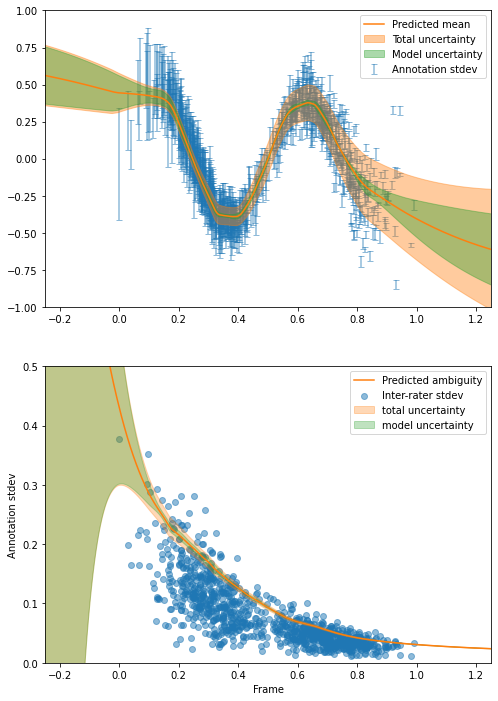

In [395]:
npresults = np.array(results)
x_test = x_test.flatten()

test = np.mean(Y,axis=1).flatten()
test_pred = np.mean(npresults[:,:,0],axis=0).flatten()
# test_std = 0.1*np.square(x_test)
test_std = np.std(Y,axis=1).flatten()
test_pred_std = np.zeros((test.shape[0],))

# num_models=10

mv_pred = np.zeros([num_models,npresults.shape[1],1,2])
dunc = np.zeros([npresults.shape[1],2,2])
for m in range(num_models):
#     test_pred_std += test_pred_nll[m,:,frame_length-1,1] + np.square(test_pred_nll[m,:,frame_length-1,0])

    mu = npresults[m,:,0].flatten()
    sigma2 = npresults[m,:,1].flatten()
    alpha = npresults[m,:,2].flatten()
    beta = npresults[m,:,3].flatten()
#     mu = npresults[m,:,2].flatten()
#     nu = npresults[m,:,3].flatten()
    
#     amb_m = beta/alpha
    amb_m = beta/(alpha-1)
    var_mu_m = sigma2
    var_amb_m = np.power(beta,2)/(alpha)
#     general_var_m = var_mu_m*var_amb_m

    mv_pred[m,:,0,0] = mu
    mv_pred[m,:,0,1] = amb_m
#   Using multivariate covariance
    dunc[:,0,0] += var_mu_m/num_models
    dunc[:,1,1] += var_amb_m/num_models

munc = np.zeros([npresults.shape[1],2,2])
munc2 = np.zeros([npresults.shape[1],2,2])
mv_pred_ave = np.mean(mv_pred,axis=0)
print(munc.shape)
for m in range(num_models):
    diff_m = mv_pred[m,:,:] - mv_pred_ave
    munc += np.matmul( diff_m.transpose(0,2,1),diff_m)
    
    munc2 += (np.square(mv_pred[m,:,:]) - np.square(mv_pred_ave))/num_models
    
#     print(diff_i[0,:,:])
#     print(diff_i.transpose(0,2,1)[0,:,:])
#     print(munc[0,:,:])
    
    
munc = munc/(num_models-1)

test_pred_std = np.sqrt(mv_pred_ave[:,0,1])
dunc_la = np.sqrt(dunc[:,0,0])
dunc_amb = np.sqrt(dunc[:,1,1])
# dunc_1 = np.sqrt(np.linalg.det(dunc))
# munc_1 = np.sqrt(np.linalg.det(munc))

fig, axs = plt.subplots(2)
fig.set_size_inches(8,12)

# axs[0].set_xlim([0,7391])
axs[0].set_xlim([-0.25,1.25])
# axs[0].set_xlim([0,1])
axs[0].set_ylim([-1,1])
# axs[0].set_xlabel('Frame')
# axs[0].set_ylabel('Arousal')
# axs[0].scatter(np.outer(X,np.ones(6)),Y,label='Annotations')
# axs[0].scatter(x_train, test, label='Mean annotations',zorder=1, alpha=0.1)
axs[0].errorbar(x_train, test, yerr=test_std, linestyle='none',zorder=1,alpha=0.5, capsize=3, label='Annotation stdev')
# axs[0].plot(x_test, (np.sin(12.5*x_test)/(np.abs(x_test)+2)), label='target mean',color='C0')
axs[0].plot(x_test, test_pred, label='Predicted mean',color='C1')
# for i in range(num_models):
#     axs[0].plot(np.abs(mv_pred[i,:,0,0]-mv_pred_ave[:,0,0])+0.5)
#     axs[0].plot(np.abs(mv_pred[i,:,0,1]-mv_pred_ave[:,0,1])-0.5)
# axs[0].plot(test_pred_unc)
munc_la = np.sqrt(munc[:,0,0])
tunc_la = np.sqrt(munc[:,0,0]+dunc[:,0,0])
# axs[0].plot(x_test, np.sqrt(munc[:,0,0])-1, label='predicted model uncertainty - 1', color='C2')
# axs[0].plot(x_test, np.sqrt(dunc[:,0,0])-1, label='predicted data uncertainty - 1', color='C3')
# axs[0].plot(x_test, test_pred_std-1, label='Predicted ambiguity - 1', color='C4')
axs[0].fill_between(x_test, test_pred-tunc_la,test_pred+tunc_la,color='C1',alpha=0.4, label='Total uncertainty',zorder=2)
axs[0].fill_between(x_test, test_pred-munc_la,test_pred+munc_la,color='C2',alpha=0.4, label='Model uncertainty',zorder=2)
axs[0].legend()
# axs[0].plot(x_test, np.sqrt(munc[:,0,0])-1)
# axs[0].plot(x_test, np.sqrt(dunc[:,0,0])-1)

# axs[1].set_xlim([0,7391])
axs[1].set_xlim([-0.25,1.25])
axs[1].set_ylim([0,0.5])
axs[1].set_xlabel('Frame')
axs[1].set_ylabel('Annotation stdev')
axs[1].scatter(x_train, test_std, label='Inter-rater stdev', alpha=0.5)
# axs[1].plot(x_test, 0.3*np.exp(x_test*-3)+0.01, label='Predicted ambiguity')
axs[1].plot(x_test, test_pred_std, label='Predicted ambiguity',color='C1')
# axs[1].plot(x_test, np.sqrt(munc[:,1,1]), label='predicted model uncertainty')
# axs[1].plot(x_test, np.sqrt(dunc[:,1,1]), label='predicted data uncertainty')
# axs[1].scatter(x_train, np.std(y_train,axis=1, ddof=1), label='Inter-rater stdev')
# axs[1].scatter(x_train, np.std(y_train,axis=1, ddof=0), label='Inter-rater stdev')
munc_amb = np.sqrt(munc[:,1,1])
tunc_amb = np.sqrt(munc[:,1,1]+dunc[:,1,1])
axs[1].fill_between(x_test, test_pred_std-tunc_amb,test_pred_std+tunc_amb,color='C1',zorder=2,alpha=0.3, label='total uncertainty')
axs[1].fill_between(x_test, test_pred_std-munc_amb,test_pred_std+munc_amb,color='C2',zorder=2,alpha=0.3, label='model uncertainty')
axs[1].legend()

# print(my_ccc(test,test_pred))
# print(my_ccc(test_std,test_pred_std))
# print(my_nll(y_test_multi, test_pred, np.sqrt(np.square(test_pred_std)+dunc[:,0,0]+munc[:,0,0])))
print(np.mean(munc[:,0,0]))
print(np.mean(dunc[:,0,0]))
print(np.mean(munc[:,1,1]))
print(np.mean(dunc[:,1,1]))

# print(np.mean(np.square((munc[:,0,0]-munc2[:,0,0]))))

In [316]:
# plt.hist(X,20)
# plt.plot(x_test, np.sqrt(munc[:,0,0])*100)
# plt.plot(x_test, np.power(munc[:,1,1],0.25)*100)
# plt.plot(x_test, np.power(np.linalg.det(munc),0.125)*100)

In [341]:
def my_dual_nll_loss(y_true, y_pred):
    
    mu = y_pred[:,0]
    sigma2 = y_pred[:,1]
    alpha = y_pred[:,2]
    beta = y_pred[:,3]
    
    num_labels = y_true.shape[1]
    y = tf.math.reduce_mean(y_true,axis=1) #annotation mean
    tol = 1/tf.math.reduce_variance(y_true,axis=1) #tolerance = 1/variance
    Vamb = (beta/(alpha-1))/num_labels
    
    nll = 0.5*(tf.math.log(sigma2+Vamb) + ((y - mu) ** 2)/(sigma2+Vamb) + 1.837877) #fit mean
    nll += beta*tol + tf.math.lgamma(alpha) - (alpha-1)*tf.math.log(tol) - alpha*tf.math.log(beta) #fit amb
    
    return nll

x_train = X.reshape((len(X),1))
y_train = Y

models2 = []
# du_models = []
# mu_models = []
# amb_models = []
num_models = 1
rcoeff = 0.001
for i in range(num_models):
    inputs = Input(shape=(1,))
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(rcoeff))(inputs)
    x = Dropout(0.1)(x, training=True)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(rcoeff))(x)
    x = Dropout(0.1)(x, training=True)
    mu = Dense(1, activation="tanh")(x)
    sigma2 = Dense(1, activation="softplus")(x)
    alpha = Dense(1, activation="softplus")(x)
    beta = Dense(1, activation="softplus")(x)
    outputs = Concatenate()([mu, sigma2 , alpha+1, beta]) #4 parameters of NIG distribution

    model_nll = keras.Model(inputs, outputs)
    model_nll.summary()

    #train model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model_nll.compile(optimizer=optimizer, loss=my_dual_nll_loss)
    
#     adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.01)
#     adv_model = nsl.keras.AdversarialRegularization(model_NIG, adv_config)
#     adv_model.compile(optimizer=optimizer, loss=my_NIG_loss)
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, verbose=0, mode='min', min_delta=0.0001, restore_best_weights=True)
    
    model_nll.fit(x_train,y_train, batch_size=5, epochs=10000, validation_split=0.1, shuffle=True, callbacks=[early_stopping])
    models2.append(model_nll)





Model: "model_181"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_183 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1092 (Dense)              (None, 64)           128         input_183[0][0]                  
__________________________________________________________________________________________________
dropout_366 (Dropout)           (None, 64)           0           dense_1092[0][0]                 
__________________________________________________________________________________________________
dense_1093 (Dense)              (None, 64)           4160        dropout_366[0][0]                
__________________________________________________________________________________________

180/180 [==============================] - 0s 705us/step - loss: 6.9715 - val_loss: 8.1019
Epoch 51/10000
180/180 [==============================] - 0s 693us/step - loss: 6.9359 - val_loss: 7.8992
Epoch 52/10000
180/180 [==============================] - 0s 710us/step - loss: 6.9486 - val_loss: 8.0348
Epoch 53/10000
180/180 [==============================] - 0s 699us/step - loss: 6.9073 - val_loss: 8.1803
Epoch 54/10000
180/180 [==============================] - 0s 699us/step - loss: 6.8815 - val_loss: 7.8575
Epoch 55/10000
180/180 [==============================] - 0s 760us/step - loss: 6.8610 - val_loss: 7.9775
Epoch 56/10000
180/180 [==============================] - 0s 727us/step - loss: 6.8424 - val_loss: 8.0967
Epoch 57/10000
180/180 [==============================] - 0s 682us/step - loss: 6.8261 - val_loss: 7.8922
Epoch 58/10000
180/180 [==============================] - 0s 682us/step - loss: 6.7689 - val_loss: 7.7406
Epoch 59/10000
180/180 [==============================] - 0s 

180/180 [==============================] - 0s 705us/step - loss: 6.4136 - val_loss: 7.4760
Epoch 128/10000
180/180 [==============================] - 0s 699us/step - loss: 6.5966 - val_loss: 7.7346
Epoch 129/10000
180/180 [==============================] - 0s 710us/step - loss: 6.4421 - val_loss: 7.6393
Epoch 130/10000
180/180 [==============================] - 0s 693us/step - loss: 6.4690 - val_loss: 7.5986
Epoch 131/10000
180/180 [==============================] - 0s 677us/step - loss: 6.4845 - val_loss: 7.6130
Epoch 132/10000
180/180 [==============================] - 0s 677us/step - loss: 6.4454 - val_loss: 7.7772
Epoch 133/10000
180/180 [==============================] - 0s 693us/step - loss: 6.4272 - val_loss: 7.5868
Epoch 134/10000
180/180 [==============================] - 0s 699us/step - loss: 6.4622 - val_loss: 7.6917
Epoch 135/10000
180/180 [==============================] - 0s 710us/step - loss: 6.4352 - val_loss: 7.5893
Epoch 136/10000
180/180 [============================

180/180 [==============================] - 0s 699us/step - loss: 6.3081 - val_loss: 7.7362
Epoch 204/10000
180/180 [==============================] - 0s 721us/step - loss: 6.4554 - val_loss: 7.5669
Epoch 205/10000
180/180 [==============================] - 0s 744us/step - loss: 6.3623 - val_loss: 7.6845
Epoch 206/10000
180/180 [==============================] - 0s 749us/step - loss: 6.3705 - val_loss: 7.5471
Epoch 207/10000
180/180 [==============================] - 0s 754us/step - loss: 6.3093 - val_loss: 7.5128
Epoch 208/10000
180/180 [==============================] - 0s 699us/step - loss: 6.3977 - val_loss: 7.7377
Epoch 209/10000
180/180 [==============================] - 0s 694us/step - loss: 6.3334 - val_loss: 7.6090
Epoch 210/10000
180/180 [==============================] - 0s 677us/step - loss: 6.3397 - val_loss: 7.7265
Epoch 211/10000
180/180 [==============================] - 0s 727us/step - loss: 6.2872 - val_loss: 7.5034
Epoch 212/10000
180/180 [============================

180/180 [==============================] - 0s 705us/step - loss: 6.3612 - val_loss: 7.5682
Epoch 280/10000
180/180 [==============================] - 0s 705us/step - loss: 6.2473 - val_loss: 7.4471
Epoch 281/10000
180/180 [==============================] - 0s 688us/step - loss: 6.2927 - val_loss: 7.5392
Epoch 282/10000
180/180 [==============================] - 0s 688us/step - loss: 6.2727 - val_loss: 7.6067
Epoch 283/10000
180/180 [==============================] - 0s 716us/step - loss: 6.2911 - val_loss: 7.5330
Epoch 284/10000
180/180 [==============================] - 0s 699us/step - loss: 6.2550 - val_loss: 7.4642
Epoch 285/10000
180/180 [==============================] - 0s 699us/step - loss: 6.2147 - val_loss: 7.6188
Epoch 286/10000
180/180 [==============================] - 0s 682us/step - loss: 6.2789 - val_loss: 7.3972
Epoch 287/10000
180/180 [==============================] - 0s 671us/step - loss: 6.2254 - val_loss: 7.6614
Epoch 288/10000
180/180 [============================

180/180 [==============================] - 0s 682us/step - loss: 6.1795 - val_loss: 7.5217
Epoch 356/10000
180/180 [==============================] - 0s 688us/step - loss: 6.2853 - val_loss: 7.5536
Epoch 357/10000
180/180 [==============================] - 0s 677us/step - loss: 6.2600 - val_loss: 7.6132
Epoch 358/10000
180/180 [==============================] - 0s 693us/step - loss: 6.2924 - val_loss: 7.5499
Epoch 359/10000
180/180 [==============================] - 0s 688us/step - loss: 6.2397 - val_loss: 7.4757
Epoch 360/10000
180/180 [==============================] - 0s 665us/step - loss: 6.2002 - val_loss: 7.5058
Epoch 361/10000
180/180 [==============================] - 0s 671us/step - loss: 6.1893 - val_loss: 7.5224
Epoch 362/10000
180/180 [==============================] - 0s 677us/step - loss: 6.2111 - val_loss: 7.5022
Epoch 363/10000
180/180 [==============================] - 0s 677us/step - loss: 6.2873 - val_loss: 7.3938
Epoch 364/10000
180/180 [============================

180/180 [==============================] - 0s 671us/step - loss: 6.2107 - val_loss: 7.4777
Epoch 432/10000
180/180 [==============================] - 0s 649us/step - loss: 6.2613 - val_loss: 7.4589
Epoch 433/10000
180/180 [==============================] - 0s 699us/step - loss: 6.2211 - val_loss: 7.5248
Epoch 434/10000
180/180 [==============================] - 0s 671us/step - loss: 6.2102 - val_loss: 7.4435
Epoch 435/10000
180/180 [==============================] - 0s 665us/step - loss: 6.1417 - val_loss: 7.2901
Epoch 436/10000
180/180 [==============================] - 0s 671us/step - loss: 6.2496 - val_loss: 7.4541
Epoch 437/10000
180/180 [==============================] - 0s 677us/step - loss: 6.1660 - val_loss: 7.5412
Epoch 438/10000
180/180 [==============================] - 0s 671us/step - loss: 6.2171 - val_loss: 7.4119
Epoch 439/10000
180/180 [==============================] - 0s 677us/step - loss: 6.2685 - val_loss: 7.4880
Epoch 440/10000
180/180 [============================

180/180 [==============================] - 0s 693us/step - loss: 6.1264 - val_loss: 7.4995
Epoch 508/10000
180/180 [==============================] - 0s 699us/step - loss: 6.2047 - val_loss: 7.5092
Epoch 509/10000
180/180 [==============================] - 0s 693us/step - loss: 6.1879 - val_loss: 7.5965
Epoch 510/10000
180/180 [==============================] - 0s 715us/step - loss: 6.2026 - val_loss: 7.5928
Epoch 511/10000
180/180 [==============================] - 0s 699us/step - loss: 6.1581 - val_loss: 7.3348
Epoch 512/10000
180/180 [==============================] - 0s 690us/step - loss: 6.1759 - val_loss: 7.4441
Epoch 513/10000
180/180 [==============================] - 0s 699us/step - loss: 6.1767 - val_loss: 7.5188
Epoch 514/10000
180/180 [==============================] - 0s 677us/step - loss: 6.2171 - val_loss: 7.5766
Epoch 515/10000
180/180 [==============================] - 0s 682us/step - loss: 6.1967 - val_loss: 7.4607
Epoch 516/10000
180/180 [============================

180/180 [==============================] - 0s 755us/step - loss: 6.2669 - val_loss: 7.4528
Epoch 584/10000
180/180 [==============================] - 0s 733us/step - loss: 6.2197 - val_loss: 7.5835
Epoch 585/10000
180/180 [==============================] - 0s 727us/step - loss: 6.1202 - val_loss: 7.5808
Epoch 586/10000
180/180 [==============================] - 0s 704us/step - loss: 6.2141 - val_loss: 7.4208
Epoch 587/10000
180/180 [==============================] - 0s 705us/step - loss: 6.1247 - val_loss: 7.6466
Epoch 588/10000
180/180 [==============================] - 0s 721us/step - loss: 6.1740 - val_loss: 7.6378
Epoch 589/10000
180/180 [==============================] - 0s 705us/step - loss: 6.2371 - val_loss: 7.4850
Epoch 590/10000
180/180 [==============================] - 0s 721us/step - loss: 6.2221 - val_loss: 7.4488
Epoch 591/10000
180/180 [==============================] - 0s 682us/step - loss: 6.1484 - val_loss: 7.4754
Epoch 592/10000
180/180 [============================

180/180 [==============================] - 0s 693us/step - loss: 6.1959 - val_loss: 7.5702
Epoch 660/10000
180/180 [==============================] - 0s 699us/step - loss: 6.1945 - val_loss: 7.5351
Epoch 661/10000
180/180 [==============================] - 0s 733us/step - loss: 6.1550 - val_loss: 7.3902
Epoch 662/10000
180/180 [==============================] - 0s 727us/step - loss: 6.1937 - val_loss: 7.4892
Epoch 663/10000
180/180 [==============================] - 0s 738us/step - loss: 6.1931 - val_loss: 7.5748
Epoch 664/10000
180/180 [==============================] - 0s 705us/step - loss: 6.1591 - val_loss: 7.4717
Epoch 665/10000
180/180 [==============================] - 0s 699us/step - loss: 6.1750 - val_loss: 7.3791
Epoch 666/10000
180/180 [==============================] - 0s 693us/step - loss: 6.1996 - val_loss: 7.4854
Epoch 667/10000
180/180 [==============================] - 0s 705us/step - loss: 6.1857 - val_loss: 7.2864
Epoch 668/10000
180/180 [============================

180/180 [==============================] - 0s 688us/step - loss: 6.1478 - val_loss: 7.4168
Epoch 736/10000
180/180 [==============================] - 0s 688us/step - loss: 6.1597 - val_loss: 7.3481
Epoch 737/10000
180/180 [==============================] - 0s 705us/step - loss: 6.1284 - val_loss: 7.4339
Epoch 738/10000
180/180 [==============================] - 0s 688us/step - loss: 6.1086 - val_loss: 7.4348
Epoch 739/10000
180/180 [==============================] - 0s 688us/step - loss: 6.1056 - val_loss: 7.6243
Epoch 740/10000
180/180 [==============================] - 0s 693us/step - loss: 6.1314 - val_loss: 7.5085
Epoch 741/10000
180/180 [==============================] - 0s 688us/step - loss: 6.1320 - val_loss: 7.3879
Epoch 742/10000
180/180 [==============================] - 0s 699us/step - loss: 6.1778 - val_loss: 7.4368
Epoch 743/10000
180/180 [==============================] - 0s 688us/step - loss: 6.1672 - val_loss: 7.3960
Epoch 744/10000
180/180 [============================

180/180 [==============================] - 0s 682us/step - loss: 6.1350 - val_loss: 7.4368
Epoch 812/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0982 - val_loss: 7.4269
Epoch 813/10000
180/180 [==============================] - 0s 681us/step - loss: 6.1436 - val_loss: 7.5615
Epoch 814/10000
180/180 [==============================] - 0s 699us/step - loss: 6.1774 - val_loss: 7.3904
Epoch 815/10000
180/180 [==============================] - 0s 691us/step - loss: 6.1374 - val_loss: 7.3621
Epoch 816/10000
180/180 [==============================] - 0s 688us/step - loss: 6.1107 - val_loss: 7.5640
Epoch 817/10000
180/180 [==============================] - 0s 693us/step - loss: 6.1305 - val_loss: 7.4364
Epoch 818/10000
180/180 [==============================] - 0s 693us/step - loss: 6.1530 - val_loss: 7.4335
Epoch 819/10000
180/180 [==============================] - 0s 693us/step - loss: 6.1454 - val_loss: 7.4012
Epoch 820/10000
180/180 [============================

180/180 [==============================] - 0s 738us/step - loss: 6.1286 - val_loss: 7.5622
Epoch 888/10000
180/180 [==============================] - 0s 727us/step - loss: 6.1026 - val_loss: 7.3632
Epoch 889/10000
180/180 [==============================] - 0s 705us/step - loss: 6.1245 - val_loss: 7.4121
Epoch 890/10000
180/180 [==============================] - 0s 710us/step - loss: 6.0793 - val_loss: 7.3382
Epoch 891/10000
180/180 [==============================] - 0s 705us/step - loss: 6.1081 - val_loss: 7.4923
Epoch 892/10000
180/180 [==============================] - 0s 738us/step - loss: 6.1107 - val_loss: 7.2787
Epoch 893/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0869 - val_loss: 7.4477
Epoch 894/10000
180/180 [==============================] - 0s 682us/step - loss: 6.1293 - val_loss: 7.3508
Epoch 895/10000
180/180 [==============================] - 0s 688us/step - loss: 6.1537 - val_loss: 7.4046
Epoch 896/10000
180/180 [============================

180/180 [==============================] - 0s 688us/step - loss: 6.0887 - val_loss: 7.4035
Epoch 964/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0849 - val_loss: 7.2952
Epoch 965/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0884 - val_loss: 7.4507
Epoch 966/10000
180/180 [==============================] - 0s 677us/step - loss: 6.0952 - val_loss: 7.4673
Epoch 967/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0819 - val_loss: 7.3301
Epoch 968/10000
180/180 [==============================] - 0s 727us/step - loss: 6.0813 - val_loss: 7.3819
Epoch 969/10000
180/180 [==============================] - 0s 727us/step - loss: 6.0962 - val_loss: 7.4558
Epoch 970/10000
180/180 [==============================] - 0s 654us/step - loss: 6.1210 - val_loss: 7.4509
Epoch 971/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0612 - val_loss: 7.4786
Epoch 972/10000
180/180 [============================

180/180 [==============================] - 0s 755us/step - loss: 6.0607 - val_loss: 7.3295
Epoch 1040/10000
180/180 [==============================] - 0s 760us/step - loss: 6.0746 - val_loss: 7.3290
Epoch 1041/10000
180/180 [==============================] - 0s 727us/step - loss: 6.1136 - val_loss: 7.3850
Epoch 1042/10000
180/180 [==============================] - 0s 699us/step - loss: 6.0719 - val_loss: 7.4767
Epoch 1043/10000
180/180 [==============================] - 0s 733us/step - loss: 6.0663 - val_loss: 7.4809
Epoch 1044/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0851 - val_loss: 7.3262
Epoch 1045/10000
180/180 [==============================] - 0s 710us/step - loss: 6.0647 - val_loss: 7.5348
Epoch 1046/10000
180/180 [==============================] - 0s 693us/step - loss: 6.1262 - val_loss: 7.1835
Epoch 1047/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0413 - val_loss: 7.2791
Epoch 1048/10000
180/180 [===================

180/180 [==============================] - 0s 699us/step - loss: 6.0291 - val_loss: 7.3178
Epoch 1116/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0467 - val_loss: 7.3402
Epoch 1117/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0459 - val_loss: 7.3854
Epoch 1118/10000
180/180 [==============================] - 0s 699us/step - loss: 6.0736 - val_loss: 7.3608
Epoch 1119/10000
180/180 [==============================] - 0s 712us/step - loss: 6.0445 - val_loss: 7.3598
Epoch 1120/10000
180/180 [==============================] - 0s 699us/step - loss: 6.0756 - val_loss: 7.3656
Epoch 1121/10000
180/180 [==============================] - 0s 687us/step - loss: 6.0940 - val_loss: 7.3823
Epoch 1122/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0841 - val_loss: 7.3586
Epoch 1123/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0514 - val_loss: 7.2839
Epoch 1124/10000
180/180 [===================

180/180 [==============================] - 0s 688us/step - loss: 6.0572 - val_loss: 7.2727
Epoch 1192/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0514 - val_loss: 7.3110
Epoch 1193/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0835 - val_loss: 7.2816
Epoch 1194/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0275 - val_loss: 7.4065
Epoch 1195/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0762 - val_loss: 7.3667
Epoch 1196/10000
180/180 [==============================] - 0s 693us/step - loss: 6.1083 - val_loss: 7.3349
Epoch 1197/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0580 - val_loss: 7.3266
Epoch 1198/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0499 - val_loss: 7.3478
Epoch 1199/10000
180/180 [==============================] - 0s 691us/step - loss: 6.0672 - val_loss: 7.3397
Epoch 1200/10000
180/180 [===================

180/180 [==============================] - 0s 693us/step - loss: 6.0427 - val_loss: 7.4374
Epoch 1268/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0497 - val_loss: 7.6194
Epoch 1269/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0281 - val_loss: 7.3371
Epoch 1270/10000
180/180 [==============================] - 0s 671us/step - loss: 6.0318 - val_loss: 7.4881
Epoch 1271/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0411 - val_loss: 7.3623
Epoch 1272/10000
180/180 [==============================] - 0s 699us/step - loss: 6.0861 - val_loss: 7.4275
Epoch 1273/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0734 - val_loss: 7.2751
Epoch 1274/10000
180/180 [==============================] - 0s 699us/step - loss: 6.0426 - val_loss: 7.3805
Epoch 1275/10000
180/180 [==============================] - 0s 693us/step - loss: 6.0416 - val_loss: 7.2981
Epoch 1276/10000
180/180 [===================

180/180 [==============================] - 0s 682us/step - loss: 6.0421 - val_loss: 7.3309
Epoch 1344/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0317 - val_loss: 7.3104
Epoch 1345/10000
180/180 [==============================] - 0s 677us/step - loss: 6.0357 - val_loss: 7.2962
Epoch 1346/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0311 - val_loss: 7.3138
Epoch 1347/10000
180/180 [==============================] - 0s 682us/step - loss: 6.0124 - val_loss: 7.2887
Epoch 1348/10000
180/180 [==============================] - 0s 665us/step - loss: 6.0305 - val_loss: 7.3131
Epoch 1349/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0371 - val_loss: 7.3843
Epoch 1350/10000
180/180 [==============================] - 0s 688us/step - loss: 6.0261 - val_loss: 7.4902
Epoch 1351/10000
180/180 [==============================] - 0s 705us/step - loss: 6.0283 - val_loss: 7.2402
Epoch 1352/10000
180/180 [===================

In [392]:
results = []
n_test = 1000
x_test = np.reshape(np.linspace(-2,3,n_test),(n_test,1))
num_models = 200
for i in range(num_models):
    print(i)
#     results.append(models2[i].predict(x_test))
    results.append(models2[0].predict(x_test))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


(1000, 2, 2)
0.13319893164366392
0.17390450134185872
11.874015369745157
0.0003645331026345834


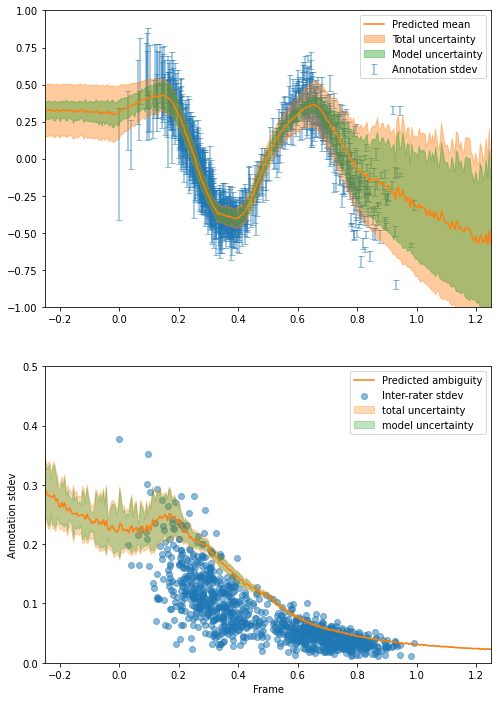

In [393]:
npresults = np.array(results)
x_test = x_test.flatten()

test = np.mean(Y,axis=1).flatten()
test_pred = np.mean(npresults[:,:,0],axis=0).flatten()
# test_std = 0.1*np.square(x_test)
test_std = np.std(Y,axis=1).flatten()
test_pred_std = np.zeros((test.shape[0],))

# num_models=10

mv_pred = np.zeros([num_models,npresults.shape[1],1,2])
dunc = np.zeros([npresults.shape[1],2,2])
for m in range(num_models):
#     test_pred_std += test_pred_nll[m,:,frame_length-1,1] + np.square(test_pred_nll[m,:,frame_length-1,0])

    mu = npresults[m,:,0].flatten()
    sigma2 = npresults[m,:,1].flatten()
    alpha = npresults[m,:,2].flatten()
    beta = npresults[m,:,3].flatten()
#     mu = npresults[m,:,2].flatten()
#     nu = npresults[m,:,3].flatten()
    
#     amb_m = beta/alpha
    amb_m = beta/(alpha-1)
    var_mu_m = sigma2
    var_amb_m = np.power(beta,2)/(alpha)
#     general_var_m = var_mu_m*var_amb_m

    mv_pred[m,:,0,0] = mu
    mv_pred[m,:,0,1] = amb_m
#   Using multivariate covariance
    dunc[:,0,0] += var_mu_m/num_models
    dunc[:,1,1] += var_amb_m/num_models

munc = np.zeros([npresults.shape[1],2,2])
munc2 = np.zeros([npresults.shape[1],2,2])
mv_pred_ave = np.mean(mv_pred,axis=0)
print(munc.shape)
for m in range(num_models):
    diff_m = mv_pred[m,:,:] - mv_pred_ave
    munc += np.matmul( diff_m.transpose(0,2,1),diff_m)
    
    munc2 += (np.square(mv_pred[m,:,:]) - np.square(mv_pred_ave))/num_models
    
#     print(diff_i[0,:,:])
#     print(diff_i.transpose(0,2,1)[0,:,:])
#     print(munc[0,:,:])
    
    
munc = munc/(num_models-1)

test_pred_std = np.sqrt(mv_pred_ave[:,0,1])
dunc_la = np.sqrt(dunc[:,0,0])
dunc_amb = np.sqrt(dunc[:,1,1])
# dunc_1 = np.sqrt(np.linalg.det(dunc))
# munc_1 = np.sqrt(np.linalg.det(munc))

fig, axs = plt.subplots(2)
fig.set_size_inches(8,12)

# axs[0].set_xlim([0,7391])
axs[0].set_xlim([-0.25,1.25])
# axs[0].set_xlim([0,1])
axs[0].set_ylim([-1,1])
# axs[0].set_xlabel('Frame')
# axs[0].set_ylabel('Arousal')
# axs[0].scatter(np.outer(X,np.ones(6)),Y,label='Annotations')
# axs[0].scatter(x_train, test, label='Mean annotations',zorder=1, alpha=0.1)
axs[0].errorbar(x_train, test, yerr=test_std, linestyle='none',zorder=1,alpha=0.5, capsize=3, label='Annotation stdev')
# axs[0].plot(x_test, (np.sin(12.5*x_test)/(np.abs(x_test)+2)), label='target mean',color='C0')
axs[0].plot(x_test, test_pred, label='Predicted mean',color='C1')
# for i in range(num_models):
#     axs[0].plot(np.abs(mv_pred[i,:,0,0]-mv_pred_ave[:,0,0])+0.5)
#     axs[0].plot(np.abs(mv_pred[i,:,0,1]-mv_pred_ave[:,0,1])-0.5)
# axs[0].plot(test_pred_unc)
munc_la = np.sqrt(munc[:,0,0])
tunc_la = np.sqrt(munc[:,0,0]+dunc[:,0,0])
# axs[0].plot(x_test, np.sqrt(munc[:,0,0])-1, label='predicted model uncertainty - 1', color='C2')
# axs[0].plot(x_test, np.sqrt(dunc[:,0,0])-1, label='predicted data uncertainty - 1', color='C3')
# axs[0].plot(x_test, test_pred_std-1, label='Predicted ambiguity - 1', color='C4')
axs[0].fill_between(x_test, test_pred-tunc_la,test_pred+tunc_la,color='C1',alpha=0.4, label='Total uncertainty',zorder=2)
axs[0].fill_between(x_test, test_pred-munc_la,test_pred+munc_la,color='C2',alpha=0.4, label='Model uncertainty',zorder=2)
axs[0].legend()
# axs[0].plot(x_test, np.sqrt(munc[:,0,0])-1)
# axs[0].plot(x_test, np.sqrt(munc2[:,0,0])-1)

# axs[1].set_xlim([0,7391])
axs[1].set_xlim([-0.25,1.25])
axs[1].set_ylim([0,0.5])
axs[1].set_xlabel('Frame')
axs[1].set_ylabel('Annotation stdev')
axs[1].scatter(x_train, test_std, label='Inter-rater stdev', alpha=0.5)
# axs[1].plot(x_test, 0.3*np.exp(x_test*-3)+0.01, label='Predicted ambiguity')
axs[1].plot(x_test, test_pred_std, label='Predicted ambiguity',color='C1')
# axs[1].plot(x_test, np.sqrt(munc[:,1,1]), label='predicted model uncertainty')
# axs[1].plot(x_test, np.sqrt(dunc[:,1,1]), label='predicted data uncertainty')
# axs[1].scatter(x_train, np.std(y_train,axis=1, ddof=1), label='Inter-rater stdev')
# axs[1].scatter(x_train, np.std(y_train,axis=1, ddof=0), label='Inter-rater stdev')
munc_amb = np.sqrt(munc[:,1,1])
tunc_amb = np.sqrt(munc[:,1,1]+dunc[:,1,1])
axs[1].fill_between(x_test, test_pred_std-tunc_amb,test_pred_std+tunc_amb,color='C1',zorder=2,alpha=0.3, label='total uncertainty')
axs[1].fill_between(x_test, test_pred_std-munc_amb,test_pred_std+munc_amb,color='C2',zorder=2,alpha=0.3, label='model uncertainty')
axs[1].legend()

# print(my_ccc(test,test_pred))
# print(my_ccc(test_std,test_pred_std))
# print(my_nll(y_test_multi, test_pred, np.sqrt(np.square(test_pred_std)+dunc[:,0,0]+munc[:,0,0])))
print(np.mean(munc[:,0,0]))
print(np.mean(dunc[:,0,0]))
print(np.mean(munc[:,1,1]))
print(np.mean(dunc[:,1,1]))


In [411]:
def my_NIG_loss(y_true, y_pred):
    #train the model on NLL loss, given the 6 annotations
    
    nll = 0
    
    #4 parameters of NIG prior
    alpha = y_pred[:,0]
    beta = y_pred[:,1]
    gamma = y_pred[:,2]
    nu = y_pred[:,3]
    gamma2 = 2*alpha*nu*y_pred[:,6]/6
    
    omega = 2*beta*(1+nu)
    rcoeff1 = 0.001
    
    #calculate nll loss as used in Amini et al.'s DER
    nll += (0.5*tf.math.log(3.14159/nu) - tf.math.multiply(alpha,tf.math.log(omega+gamma2))+tf.math.lgamma(alpha)-tf.math.lgamma(alpha+0.5))
    
    #component of nll dependent on labels:
    y = tf.math.reduce_mean(y_true,axis=1)
    nll += tf.math.multiply((alpha+0.5),tf.math.log(tf.math.square(y-gamma)*nu+omega+gamma2))
    #regulariser
    nll += rcoeff1*tf.math.multiply(tf.math.abs(y-gamma),(2*nu+alpha))

    
    #repeat for ambiguity estimate
    alpha = y_pred[:,4]
    beta = y_pred[:,5]
    gamma = y_pred[:,6]
    nu = y_pred[:,7]
    
    omega = 2*beta*(1+nu)
    rcoeff1 = 0.001
    
    nll += (0.5*tf.math.log(3.14159/nu) - tf.math.multiply(alpha,tf.math.log(omega))+tf.math.lgamma(alpha)-tf.math.lgamma(alpha+0.5))
    y = tf.math.reduce_variance(y_true,axis=1)
    nll += tf.math.multiply((alpha+0.5),tf.math.log(tf.math.multiply(tf.math.square(y-gamma),nu)+omega))
    nll += rcoeff1*tf.math.multiply(tf.math.abs(y-gamma),(2*nu+alpha))
    
    
    return nll

x_train = X.reshape((len(X),1))
y_train = Y

models3 = []
# du_models = []
# mu_models = []
# amb_models = []
num_models = 1
rcoeff = 0
for i in range(num_models):
    inputs = Input(shape=(1,))
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(rcoeff))(inputs)
    x = Dropout(0.1)(x)#, training=True)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(rcoeff))(x)
    x = Dropout(0.1)(x)#, training=True)
    alpha = Dense(1, activation="softplus")(x)
    beta = Dense(1, activation="softplus")(x)
    gamma = Dense(1, activation="tanh")(x)
    nu = Dense(1, activation="softplus")(x)

    alpha_var = Dense(1, activation="softplus")(x)
    beta_var = Dense(1, activation="softplus")(x)
    gamma_var = Dense(1, activation="softplus")(x)
    nu_var = Dense(1, activation="softplus")(x)
    outputs = Concatenate()([alpha+1, beta, gamma, nu ,alpha_var+1, beta_var, gamma_var, nu_var]) #4 parameters of NIG distribution x2

    model_NIG = keras.Model(inputs, outputs)
    model_NIG.summary()

    #train model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model_NIG.compile(optimizer=optimizer, loss=my_NIG_loss)
    
#     adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.01)
#     adv_model = nsl.keras.AdversarialRegularization(model_NIG, adv_config)
#     adv_model.compile(optimizer=optimizer, loss=my_NIG_loss)
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, verbose=0, mode='min', min_delta=0.0001, restore_best_weights=True)
    
    model_NIG.fit(x_train,y_train, batch_size=5, epochs=10000, validation_split=0.1, shuffle=True, callbacks=[early_stopping])
    models3.append(model_NIG)


Model: "model_194"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_196 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1218 (Dense)              (None, 64)           128         input_196[0][0]                  
__________________________________________________________________________________________________
dropout_392 (Dropout)           (None, 64)           0           dense_1218[0][0]                 
__________________________________________________________________________________________________
dense_1219 (Dense)              (None, 64)           4160        dropout_392[0][0]                
__________________________________________________________________________________________

180/180 [==============================] - 0s 811us/step - loss: -3.6654 - val_loss: -5.1387
Epoch 37/10000
180/180 [==============================] - 0s 828us/step - loss: -3.7015 - val_loss: -5.0118
Epoch 38/10000
180/180 [==============================] - 0s 822us/step - loss: -3.7053 - val_loss: -5.2475
Epoch 39/10000
180/180 [==============================] - 0s 822us/step - loss: -3.6745 - val_loss: -5.2391
Epoch 40/10000
180/180 [==============================] - 0s 822us/step - loss: -3.6921 - val_loss: -4.8374
Epoch 41/10000
180/180 [==============================] - 0s 816us/step - loss: -3.5951 - val_loss: -5.1082
Epoch 42/10000
180/180 [==============================] - 0s 816us/step - loss: -3.6788 - val_loss: -5.1189
Epoch 43/10000
180/180 [==============================] - 0s 839us/step - loss: -3.7007 - val_loss: -4.9693
Epoch 44/10000
180/180 [==============================] - 0s 833us/step - loss: -3.7041 - val_loss: -5.1559
Epoch 45/10000
180/180 [===================

Epoch 112/10000
180/180 [==============================] - 0s 850us/step - loss: -4.1966 - val_loss: -5.1361
Epoch 113/10000
180/180 [==============================] - 0s 800us/step - loss: -4.1810 - val_loss: -5.2608
Epoch 114/10000
180/180 [==============================] - 0s 783us/step - loss: -4.1974 - val_loss: -5.1269
Epoch 115/10000
180/180 [==============================] - 0s 794us/step - loss: -4.2205 - val_loss: -5.2846
Epoch 116/10000
180/180 [==============================] - 0s 805us/step - loss: -4.2391 - val_loss: -5.2851
Epoch 117/10000
180/180 [==============================] - 0s 816us/step - loss: -4.2002 - val_loss: -5.2319
Epoch 118/10000
180/180 [==============================] - 0s 811us/step - loss: -4.1933 - val_loss: -5.2886
Epoch 119/10000
180/180 [==============================] - 0s 828us/step - loss: -4.2171 - val_loss: -5.2070
Epoch 120/10000
180/180 [==============================] - 0s 995us/step - loss: -4.2488 - val_loss: -5.2223
Epoch 121/10000
180

180/180 [==============================] - 0s 833us/step - loss: -4.3871 - val_loss: -5.3975
Epoch 188/10000
180/180 [==============================] - 0s 811us/step - loss: -4.4160 - val_loss: -5.3449
Epoch 189/10000
180/180 [==============================] - 0s 800us/step - loss: -4.4058 - val_loss: -5.4540
Epoch 190/10000
180/180 [==============================] - 0s 800us/step - loss: -4.4054 - val_loss: -5.2004
Epoch 191/10000
180/180 [==============================] - 0s 788us/step - loss: -4.4271 - val_loss: -5.3580
Epoch 192/10000
180/180 [==============================] - 0s 783us/step - loss: -4.4089 - val_loss: -5.4115
Epoch 193/10000
180/180 [==============================] - 0s 794us/step - loss: -4.3505 - val_loss: -5.3520
Epoch 194/10000
180/180 [==============================] - 0s 777us/step - loss: -4.3753 - val_loss: -5.3280
Epoch 195/10000
180/180 [==============================] - 0s 816us/step - loss: -4.4241 - val_loss: -5.4028
Epoch 196/10000
180/180 [==========

180/180 [==============================] - 0s 833us/step - loss: -4.5487 - val_loss: -5.5161
Epoch 263/10000
180/180 [==============================] - 0s 828us/step - loss: -4.4662 - val_loss: -5.6349
Epoch 264/10000
180/180 [==============================] - 0s 826us/step - loss: -4.5218 - val_loss: -5.7588
Epoch 265/10000
180/180 [==============================] - 0s 804us/step - loss: -4.5035 - val_loss: -5.6435
Epoch 266/10000
180/180 [==============================] - 0s 827us/step - loss: -4.4673 - val_loss: -5.6870
Epoch 267/10000
180/180 [==============================] - 0s 816us/step - loss: -4.5625 - val_loss: -5.6852
Epoch 268/10000
180/180 [==============================] - 0s 828us/step - loss: -4.4128 - val_loss: -5.6653
Epoch 269/10000
180/180 [==============================] - 0s 805us/step - loss: -4.5958 - val_loss: -5.6315
Epoch 270/10000
180/180 [==============================] - 0s 811us/step - loss: -4.4835 - val_loss: -5.4145
Epoch 271/10000
180/180 [==========

180/180 [==============================] - 0s 839us/step - loss: -4.5815 - val_loss: -5.6807
Epoch 338/10000
180/180 [==============================] - 0s 816us/step - loss: -4.5458 - val_loss: -5.8322
Epoch 339/10000
180/180 [==============================] - 0s 858us/step - loss: -4.5663 - val_loss: -5.6945
Epoch 340/10000
180/180 [==============================] - 0s 916us/step - loss: -4.5460 - val_loss: -5.7093
Epoch 341/10000
180/180 [==============================] - 0s 912us/step - loss: -4.5687 - val_loss: -5.7238
Epoch 342/10000
180/180 [==============================] - 0s 867us/step - loss: -4.5966 - val_loss: -5.7578
Epoch 343/10000
180/180 [==============================] - 0s 833us/step - loss: -4.5247 - val_loss: -5.7381
Epoch 344/10000
180/180 [==============================] - 0s 849us/step - loss: -4.5360 - val_loss: -5.7624
Epoch 345/10000
180/180 [==============================] - 0s 827us/step - loss: -4.5614 - val_loss: -5.4816
Epoch 346/10000
180/180 [==========

180/180 [==============================] - 0s 882us/step - loss: -4.6013 - val_loss: -5.7464
Epoch 413/10000
180/180 [==============================] - 0s 816us/step - loss: -4.5743 - val_loss: -5.7743
Epoch 414/10000
180/180 [==============================] - 0s 788us/step - loss: -4.6350 - val_loss: -5.8916
Epoch 415/10000
180/180 [==============================] - 0s 805us/step - loss: -4.6050 - val_loss: -5.5982
Epoch 416/10000
180/180 [==============================] - 0s 822us/step - loss: -4.6636 - val_loss: -5.7996
Epoch 417/10000
180/180 [==============================] - 0s 816us/step - loss: -4.6420 - val_loss: -5.8969
Epoch 418/10000
180/180 [==============================] - 0s 833us/step - loss: -4.6265 - val_loss: -5.7182
Epoch 419/10000
180/180 [==============================] - 0s 911us/step - loss: -4.6216 - val_loss: -5.8612
Epoch 420/10000
180/180 [==============================] - 0s 907us/step - loss: -4.5679 - val_loss: -5.8853
Epoch 421/10000
180/180 [==========

180/180 [==============================] - 0s 906us/step - loss: -4.6663 - val_loss: -5.6826
Epoch 488/10000
180/180 [==============================] - 0s 911us/step - loss: -4.6075 - val_loss: -5.6681
Epoch 489/10000
180/180 [==============================] - 0s 894us/step - loss: -4.6403 - val_loss: -5.9133
Epoch 490/10000
180/180 [==============================] - 0s 878us/step - loss: -4.6452 - val_loss: -5.7937
Epoch 491/10000
180/180 [==============================] - 0s 934us/step - loss: -4.6586 - val_loss: -5.8349
Epoch 492/10000
180/180 [==============================] - 0s 854us/step - loss: -4.6507 - val_loss: -5.8176
Epoch 493/10000
180/180 [==============================] - 0s 816us/step - loss: -4.6531 - val_loss: -5.8083
Epoch 494/10000
180/180 [==============================] - 0s 850us/step - loss: -4.6218 - val_loss: -5.8725
Epoch 495/10000
180/180 [==============================] - 0s 861us/step - loss: -4.6668 - val_loss: -5.8810
Epoch 496/10000
180/180 [==========

180/180 [==============================] - 0s 839us/step - loss: -4.7103 - val_loss: -5.9384
Epoch 563/10000
180/180 [==============================] - 0s 850us/step - loss: -4.6350 - val_loss: -5.6982
Epoch 564/10000
180/180 [==============================] - 0s 839us/step - loss: -4.7156 - val_loss: -5.6742
Epoch 565/10000
180/180 [==============================] - 0s 839us/step - loss: -4.6457 - val_loss: -5.8072
Epoch 566/10000
180/180 [==============================] - 0s 811us/step - loss: -4.6594 - val_loss: -5.8479
Epoch 567/10000
180/180 [==============================] - 0s 815us/step - loss: -4.7251 - val_loss: -5.8453
Epoch 568/10000
180/180 [==============================] - 0s 838us/step - loss: -4.6437 - val_loss: -5.9190
Epoch 569/10000
180/180 [==============================] - 0s 833us/step - loss: -4.6558 - val_loss: -5.7650
Epoch 570/10000
180/180 [==============================] - 0s 861us/step - loss: -4.6124 - val_loss: -5.9703
Epoch 571/10000
180/180 [==========

180/180 [==============================] - 0s 833us/step - loss: -4.6675 - val_loss: -5.8112
Epoch 638/10000
180/180 [==============================] - 0s 911us/step - loss: -4.6925 - val_loss: -5.9829
Epoch 639/10000
180/180 [==============================] - 0s 917us/step - loss: -4.7064 - val_loss: -5.9826
Epoch 640/10000
180/180 [==============================] - 0s 872us/step - loss: -4.6290 - val_loss: -5.9135
Epoch 641/10000
180/180 [==============================] - 0s 872us/step - loss: -4.7227 - val_loss: -5.9827
Epoch 642/10000
180/180 [==============================] - 0s 822us/step - loss: -4.7034 - val_loss: -5.9672
Epoch 643/10000
180/180 [==============================] - 0s 878us/step - loss: -4.6992 - val_loss: -5.9810
Epoch 644/10000
180/180 [==============================] - 0s 872us/step - loss: -4.7480 - val_loss: -5.9658
Epoch 645/10000
180/180 [==============================] - 0s 888us/step - loss: -4.7533 - val_loss: -5.8837
Epoch 646/10000
180/180 [==========

180/180 [==============================] - 0s 822us/step - loss: -4.7373 - val_loss: -5.9040
Epoch 713/10000
180/180 [==============================] - 0s 856us/step - loss: -4.7295 - val_loss: -5.9498
Epoch 714/10000
180/180 [==============================] - 0s 900us/step - loss: -4.7451 - val_loss: -5.9170
Epoch 715/10000
180/180 [==============================] - 0s 811us/step - loss: -4.6948 - val_loss: -5.8095
Epoch 716/10000
180/180 [==============================] - 0s 805us/step - loss: -4.7149 - val_loss: -5.8307
Epoch 717/10000
180/180 [==============================] - 0s 816us/step - loss: -4.7468 - val_loss: -5.9163
Epoch 718/10000
180/180 [==============================] - 0s 911us/step - loss: -4.6661 - val_loss: -5.7811
Epoch 719/10000
180/180 [==============================] - 0s 917us/step - loss: -4.6942 - val_loss: -5.9964
Epoch 720/10000
180/180 [==============================] - 0s 833us/step - loss: -4.7077 - val_loss: -5.9142
Epoch 721/10000
180/180 [==========

180/180 [==============================] - 0s 828us/step - loss: -4.7249 - val_loss: -6.0272
Epoch 788/10000
180/180 [==============================] - 0s 833us/step - loss: -4.6926 - val_loss: -5.8688
Epoch 789/10000
180/180 [==============================] - 0s 811us/step - loss: -4.7164 - val_loss: -5.9972
Epoch 790/10000
180/180 [==============================] - 0s 911us/step - loss: -4.7432 - val_loss: -5.8498
Epoch 791/10000
180/180 [==============================] - 0s 861us/step - loss: -4.6875 - val_loss: -5.8763
Epoch 792/10000
180/180 [==============================] - 0s 925us/step - loss: -4.7257 - val_loss: -5.9244
Epoch 793/10000
180/180 [==============================] - 0s 900us/step - loss: -4.7457 - val_loss: -5.8422
Epoch 794/10000
180/180 [==============================] - 0s 844us/step - loss: -4.7122 - val_loss: -5.9657
Epoch 795/10000
180/180 [==============================] - 0s 914us/step - loss: -4.7505 - val_loss: -5.9830
Epoch 796/10000
180/180 [==========

180/180 [==============================] - 0s 800us/step - loss: -4.7136 - val_loss: -5.9110
Epoch 863/10000
180/180 [==============================] - 0s 828us/step - loss: -4.7410 - val_loss: -5.9437
Epoch 864/10000
180/180 [==============================] - 0s 850us/step - loss: -4.7266 - val_loss: -5.9652
Epoch 865/10000
180/180 [==============================] - 0s 850us/step - loss: -4.7337 - val_loss: -5.8821
Epoch 866/10000
180/180 [==============================] - 0s 856us/step - loss: -4.7363 - val_loss: -5.8306
Epoch 867/10000
180/180 [==============================] - 0s 861us/step - loss: -4.7245 - val_loss: -5.9354
Epoch 868/10000
180/180 [==============================] - 0s 849us/step - loss: -4.7127 - val_loss: -6.0037
Epoch 869/10000
180/180 [==============================] - 0s 828us/step - loss: -4.7540 - val_loss: -5.8958
Epoch 870/10000
180/180 [==============================] - 0s 822us/step - loss: -4.7834 - val_loss: -5.9211
Epoch 871/10000
180/180 [==========

180/180 [==============================] - 0s 889us/step - loss: -4.7461 - val_loss: -5.9807
Epoch 938/10000
180/180 [==============================] - 0s 883us/step - loss: -4.7762 - val_loss: -6.0067
Epoch 939/10000
180/180 [==============================] - 0s 833us/step - loss: -4.7610 - val_loss: -5.9258
Epoch 940/10000
180/180 [==============================] - 0s 839us/step - loss: -4.7794 - val_loss: -5.9903
Epoch 941/10000
180/180 [==============================] - 0s 839us/step - loss: -4.7560 - val_loss: -6.0180
Epoch 942/10000
180/180 [==============================] - 0s 900us/step - loss: -4.7875 - val_loss: -5.9665
Epoch 943/10000
180/180 [==============================] - 0s 883us/step - loss: -4.8143 - val_loss: -5.9216
Epoch 944/10000
180/180 [==============================] - 0s 973us/step - loss: -4.7634 - val_loss: -5.8301
Epoch 945/10000
180/180 [==============================] - 0s 939us/step - loss: -4.7582 - val_loss: -5.9703
Epoch 946/10000
180/180 [==========

180/180 [==============================] - 0s 828us/step - loss: -4.7867 - val_loss: -6.0015
Epoch 1013/10000
180/180 [==============================] - 0s 828us/step - loss: -4.8050 - val_loss: -6.0303
Epoch 1014/10000
180/180 [==============================] - 0s 856us/step - loss: -4.8074 - val_loss: -5.9735
Epoch 1015/10000
180/180 [==============================] - 0s 895us/step - loss: -4.7770 - val_loss: -5.8247
Epoch 1016/10000
180/180 [==============================] - 0s 839us/step - loss: -4.7551 - val_loss: -6.0236
Epoch 1017/10000
180/180 [==============================] - 0s 816us/step - loss: -4.8143 - val_loss: -5.8992
Epoch 1018/10000
180/180 [==============================] - 0s 872us/step - loss: -4.7634 - val_loss: -5.9886
Epoch 1019/10000
180/180 [==============================] - 0s 828us/step - loss: -4.7944 - val_loss: -6.0304
Epoch 1020/10000
180/180 [==============================] - 0s 917us/step - loss: -4.7701 - val_loss: -5.9441
Epoch 1021/10000
180/180 [=

180/180 [==============================] - 0s 828us/step - loss: -4.7428 - val_loss: -5.8152
Epoch 1087/10000
180/180 [==============================] - 0s 811us/step - loss: -4.8050 - val_loss: -5.8977
Epoch 1088/10000
180/180 [==============================] - 0s 805us/step - loss: -4.8249 - val_loss: -5.9734
Epoch 1089/10000
180/180 [==============================] - 0s 822us/step - loss: -4.7894 - val_loss: -5.8645
Epoch 1090/10000
180/180 [==============================] - 0s 828us/step - loss: -4.8110 - val_loss: -6.0317
Epoch 1091/10000
180/180 [==============================] - 0s 811us/step - loss: -4.8192 - val_loss: -6.0378
Epoch 1092/10000
180/180 [==============================] - 0s 833us/step - loss: -4.7817 - val_loss: -6.0247
Epoch 1093/10000
180/180 [==============================] - 0s 828us/step - loss: -4.8042 - val_loss: -6.0129
Epoch 1094/10000
180/180 [==============================] - 0s 847us/step - loss: -4.7478 - val_loss: -5.9727
Epoch 1095/10000
180/180 [=

180/180 [==============================] - 0s 828us/step - loss: -4.7843 - val_loss: -5.8678
Epoch 1161/10000
180/180 [==============================] - 0s 833us/step - loss: -4.8312 - val_loss: -6.0013
Epoch 1162/10000
180/180 [==============================] - 0s 844us/step - loss: -4.8195 - val_loss: -6.0482
Epoch 1163/10000
180/180 [==============================] - 0s 850us/step - loss: -4.8216 - val_loss: -6.0278
Epoch 1164/10000
180/180 [==============================] - 0s 833us/step - loss: -4.8503 - val_loss: -6.0173
Epoch 1165/10000
180/180 [==============================] - 0s 839us/step - loss: -4.7976 - val_loss: -5.8872
Epoch 1166/10000
180/180 [==============================] - 0s 861us/step - loss: -4.7943 - val_loss: -5.9712
Epoch 1167/10000
180/180 [==============================] - 0s 811us/step - loss: -4.8262 - val_loss: -5.9618
Epoch 1168/10000
180/180 [==============================] - 0s 811us/step - loss: -4.8144 - val_loss: -6.0523
Epoch 1169/10000
180/180 [=

180/180 [==============================] - 0s 962us/step - loss: -4.8329 - val_loss: -5.9966
Epoch 1235/10000
180/180 [==============================] - 0s 895us/step - loss: -4.8252 - val_loss: -5.9517
Epoch 1236/10000
180/180 [==============================] - 0s 889us/step - loss: -4.8031 - val_loss: -6.0153
Epoch 1237/10000
180/180 [==============================] - 0s 883us/step - loss: -4.8361 - val_loss: -5.8732
Epoch 1238/10000
180/180 [==============================] - 0s 1ms/step - loss: -4.8158 - val_loss: -5.9701
Epoch 1239/10000
180/180 [==============================] - 0s 945us/step - loss: -4.8401 - val_loss: -5.8661
Epoch 1240/10000
180/180 [==============================] - 0s 867us/step - loss: -4.7774 - val_loss: -5.9720
Epoch 1241/10000
180/180 [==============================] - 0s 816us/step - loss: -4.8192 - val_loss: -5.9383
Epoch 1242/10000
180/180 [==============================] - 0s 900us/step - loss: -4.8118 - val_loss: -5.9799
Epoch 1243/10000
180/180 [===

Epoch 1309/10000
180/180 [==============================] - 0s 979us/step - loss: -4.8404 - val_loss: -5.9062
Epoch 1310/10000
180/180 [==============================] - 0s 850us/step - loss: -4.7891 - val_loss: -5.9265
Epoch 1311/10000
180/180 [==============================] - 0s 822us/step - loss: -4.8240 - val_loss: -5.8902
Epoch 1312/10000
180/180 [==============================] - 0s 839us/step - loss: -4.8346 - val_loss: -5.9962
Epoch 1313/10000
180/180 [==============================] - 0s 800us/step - loss: -4.8853 - val_loss: -6.0397
Epoch 1314/10000
180/180 [==============================] - 0s 802us/step - loss: -4.8268 - val_loss: -6.0116
Epoch 1315/10000
180/180 [==============================] - 0s 827us/step - loss: -4.8115 - val_loss: -6.0376
Epoch 1316/10000
180/180 [==============================] - 0s 867us/step - loss: -4.8686 - val_loss: -5.9446
Epoch 1317/10000
180/180 [==============================] - 0s 928us/step - loss: -4.8070 - val_loss: -5.9548
Epoch 1318

180/180 [==============================] - 0s 788us/step - loss: -4.8439 - val_loss: -5.8661
Epoch 1384/10000
180/180 [==============================] - 0s 777us/step - loss: -4.8729 - val_loss: -5.9753
Epoch 1385/10000
180/180 [==============================] - 0s 788us/step - loss: -4.8312 - val_loss: -6.0077
Epoch 1386/10000
180/180 [==============================] - 0s 772us/step - loss: -4.8267 - val_loss: -6.0683
Epoch 1387/10000
180/180 [==============================] - 0s 772us/step - loss: -4.8419 - val_loss: -6.0656
Epoch 1388/10000
180/180 [==============================] - 0s 772us/step - loss: -4.8357 - val_loss: -5.9723
Epoch 1389/10000
180/180 [==============================] - 0s 811us/step - loss: -4.8687 - val_loss: -6.0278
Epoch 1390/10000
180/180 [==============================] - 0s 794us/step - loss: -4.8374 - val_loss: -5.9422
Epoch 1391/10000
180/180 [==============================] - 0s 788us/step - loss: -4.8642 - val_loss: -6.0502
Epoch 1392/10000
180/180 [=

180/180 [==============================] - 0s 805us/step - loss: -4.8170 - val_loss: -5.8725
Epoch 1458/10000
180/180 [==============================] - 0s 816us/step - loss: -4.8586 - val_loss: -6.0358
Epoch 1459/10000
180/180 [==============================] - 0s 828us/step - loss: -4.8619 - val_loss: -6.0303
Epoch 1460/10000
180/180 [==============================] - 0s 844us/step - loss: -4.8315 - val_loss: -5.9019
Epoch 1461/10000
180/180 [==============================] - 0s 828us/step - loss: -4.8314 - val_loss: -6.0012
Epoch 1462/10000
180/180 [==============================] - 0s 844us/step - loss: -4.8427 - val_loss: -5.9153
Epoch 1463/10000
180/180 [==============================] - 0s 805us/step - loss: -4.8187 - val_loss: -6.0059
Epoch 1464/10000
180/180 [==============================] - 0s 805us/step - loss: -4.8094 - val_loss: -6.0190
Epoch 1465/10000
180/180 [==============================] - 0s 811us/step - loss: -4.8354 - val_loss: -6.0173
Epoch 1466/10000
180/180 [=

180/180 [==============================] - 0s 811us/step - loss: -4.8197 - val_loss: -5.9609
Epoch 1532/10000
180/180 [==============================] - 0s 783us/step - loss: -4.9071 - val_loss: -6.0427
Epoch 1533/10000
180/180 [==============================] - 0s 839us/step - loss: -4.8815 - val_loss: -5.9473
Epoch 1534/10000
180/180 [==============================] - 0s 788us/step - loss: -4.8541 - val_loss: -5.8440
Epoch 1535/10000
180/180 [==============================] - 0s 788us/step - loss: -4.8321 - val_loss: -6.0697
Epoch 1536/10000
180/180 [==============================] - 0s 794us/step - loss: -4.8563 - val_loss: -6.0045
Epoch 1537/10000
180/180 [==============================] - 0s 777us/step - loss: -4.8590 - val_loss: -5.9279
Epoch 1538/10000
180/180 [==============================] - 0s 772us/step - loss: -4.8812 - val_loss: -5.9193
Epoch 1539/10000
180/180 [==============================] - 0s 788us/step - loss: -4.8661 - val_loss: -6.0503
Epoch 1540/10000
180/180 [=

180/180 [==============================] - 0s 822us/step - loss: -4.8838 - val_loss: -6.0616
Epoch 1606/10000
180/180 [==============================] - 0s 783us/step - loss: -4.8379 - val_loss: -6.0644
Epoch 1607/10000
180/180 [==============================] - 0s 788us/step - loss: -4.8611 - val_loss: -5.9416
Epoch 1608/10000
180/180 [==============================] - 0s 805us/step - loss: -4.8464 - val_loss: -5.9408
Epoch 1609/10000
180/180 [==============================] - 0s 800us/step - loss: -4.8679 - val_loss: -6.0563
Epoch 1610/10000
180/180 [==============================] - 0s 800us/step - loss: -4.8627 - val_loss: -5.8489
Epoch 1611/10000
180/180 [==============================] - 0s 794us/step - loss: -4.8627 - val_loss: -5.9770
Epoch 1612/10000
180/180 [==============================] - 0s 794us/step - loss: -4.8628 - val_loss: -6.0283
Epoch 1613/10000
180/180 [==============================] - 0s 822us/step - loss: -4.8440 - val_loss: -5.9674
Epoch 1614/10000
180/180 [=

180/180 [==============================] - 0s 805us/step - loss: -4.8693 - val_loss: -6.0465
Epoch 1680/10000
180/180 [==============================] - 0s 805us/step - loss: -4.8640 - val_loss: -5.9408
Epoch 1681/10000
180/180 [==============================] - 0s 805us/step - loss: -4.8692 - val_loss: -5.9953
Epoch 1682/10000
180/180 [==============================] - 0s 811us/step - loss: -4.8356 - val_loss: -5.8798
Epoch 1683/10000
180/180 [==============================] - 0s 805us/step - loss: -4.8797 - val_loss: -5.9644
Epoch 1684/10000
180/180 [==============================] - 0s 872us/step - loss: -4.8377 - val_loss: -5.9075
Epoch 1685/10000
180/180 [==============================] - 0s 805us/step - loss: -4.8892 - val_loss: -6.0294
Epoch 1686/10000
180/180 [==============================] - 0s 800us/step - loss: -4.8626 - val_loss: -5.8699
Epoch 1687/10000
180/180 [==============================] - 0s 783us/step - loss: -4.8660 - val_loss: -5.9405
Epoch 1688/10000
180/180 [=

180/180 [==============================] - 0s 800us/step - loss: -4.8864 - val_loss: -5.9287
Epoch 1754/10000
180/180 [==============================] - 0s 828us/step - loss: -4.8774 - val_loss: -6.0237
Epoch 1755/10000
180/180 [==============================] - 0s 794us/step - loss: -4.8761 - val_loss: -5.9503
Epoch 1756/10000
180/180 [==============================] - 0s 749us/step - loss: -4.8981 - val_loss: -6.0591
Epoch 1757/10000
180/180 [==============================] - 0s 794us/step - loss: -4.8587 - val_loss: -6.0113
Epoch 1758/10000
180/180 [==============================] - 0s 777us/step - loss: -4.9012 - val_loss: -5.8719
Epoch 1759/10000
180/180 [==============================] - 0s 799us/step - loss: -4.8564 - val_loss: -5.9733
Epoch 1760/10000
180/180 [==============================] - 0s 777us/step - loss: -4.8703 - val_loss: -6.0651
Epoch 1761/10000
180/180 [==============================] - 0s 783us/step - loss: -4.9075 - val_loss: -6.0531
Epoch 1762/10000
180/180 [=

180/180 [==============================] - 0s 772us/step - loss: -4.8759 - val_loss: -5.8741
Epoch 1828/10000
180/180 [==============================] - 0s 766us/step - loss: -4.8784 - val_loss: -6.0344
Epoch 1829/10000
180/180 [==============================] - 0s 792us/step - loss: -4.8503 - val_loss: -6.0521
Epoch 1830/10000
180/180 [==============================] - 0s 828us/step - loss: -4.9021 - val_loss: -5.9204
Epoch 1831/10000
180/180 [==============================] - 0s 777us/step - loss: -4.8827 - val_loss: -6.0390
Epoch 1832/10000
180/180 [==============================] - 0s 800us/step - loss: -4.8694 - val_loss: -5.9226
Epoch 1833/10000
180/180 [==============================] - 0s 828us/step - loss: -4.8974 - val_loss: -5.9805
Epoch 1834/10000
180/180 [==============================] - 0s 788us/step - loss: -4.8825 - val_loss: -6.0411
Epoch 1835/10000
180/180 [==============================] - 0s 800us/step - loss: -4.8928 - val_loss: -5.9938
Epoch 1836/10000
180/180 [=

180/180 [==============================] - 0s 805us/step - loss: -4.8806 - val_loss: -6.0521
Epoch 1902/10000
180/180 [==============================] - 0s 816us/step - loss: -4.8879 - val_loss: -6.0238
Epoch 1903/10000
180/180 [==============================] - 0s 816us/step - loss: -4.8901 - val_loss: -5.8372
Epoch 1904/10000
180/180 [==============================] - 0s 788us/step - loss: -4.8938 - val_loss: -5.8956
Epoch 1905/10000
180/180 [==============================] - 0s 811us/step - loss: -4.9097 - val_loss: -6.0513
Epoch 1906/10000
180/180 [==============================] - 0s 794us/step - loss: -4.8836 - val_loss: -5.9888
Epoch 1907/10000
180/180 [==============================] - 0s 794us/step - loss: -4.8812 - val_loss: -5.9634
Epoch 1908/10000
180/180 [==============================] - 0s 783us/step - loss: -4.8660 - val_loss: -6.0074
Epoch 1909/10000
180/180 [==============================] - 0s 777us/step - loss: -4.8898 - val_loss: -6.0065
Epoch 1910/10000
180/180 [=

0
(1, 1000, 4)


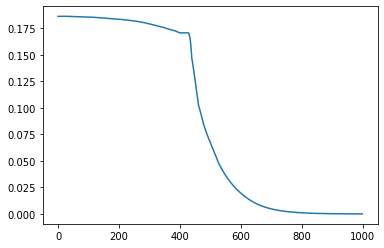

In [412]:
results = []
n_test = 1000
x_test = np.reshape(np.linspace(-2,3,n_test),(n_test,1))
num_models = 1
for i in range(num_models):
    print(i)
#     results.append(models2[i].predict(x_test))
    results.append(models3[0].predict(x_test))
    
print(npresults[:,:,0:4].shape)
plt.plot(pred_amb)

0.06446454182853575
0.29991054827787533
nan
0.052377131822746864


C:\Users\Hazmeme\AppData\Local\Temp/ipykernel_5488/2740680216.py:33: RuntimeWarning: divide by zero encountered in true_divide
  dunc_amb = beta2/(alpha2-1)


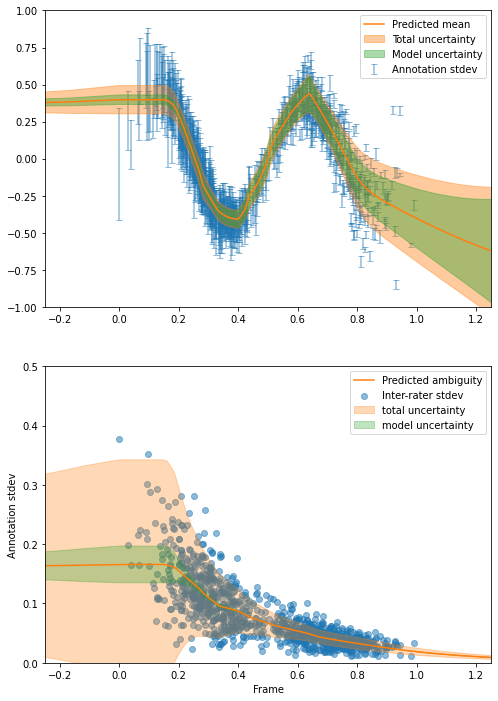

In [413]:
npresults = np.array(results)
results_mean = npresults[:,:,0:4]
results_var = npresults[:,:,4:8]
x_test = x_test.flatten()

test = np.mean(Y,axis=1).flatten()
test_pred = np.mean(npresults[:,:,0],axis=0).flatten()
# test_std = 0.1*np.square(x_test)
test_std = np.std(Y,axis=1).flatten()
test_pred_std = np.zeros((test.shape[0],))

# #test data
# test = y_test[:,0].flatten()
# test_var = y_test_var[:,0].flatten()

#model predictions
pred_mean = results_mean[:,:,2].flatten()
pred_amb = np.sqrt(results_var[:,:,2].flatten())

##uncertainty
alpha = results_mean[:,:,0].flatten()
beta = results_mean[:,:,1].flatten()
gamma = results_mean[:,:,2].flatten()
nu = results_mean[:,:,3].flatten()

alpha2 = results_var[:,:,0].flatten()
beta2 = results_var[:,:,1].flatten()
gamma2 = results_var[:,:,2].flatten()
nu2 = results_var[:,:,3].flatten()

#data uncertainty
dunc_mean = beta/(alpha-1)
dunc_amb = beta2/(alpha2-1)

#model uncertainty
munc_mean = dunc_mean/nu
munc_amb = dunc_amb/nu2

#total uncertainty
tunc_mean = np.sqrt(munc_mean+dunc_mean)
tunc_amb = np.sqrt(munc_amb+dunc_amb)

fig, axs = plt.subplots(2)
fig.set_size_inches(8,12)

# axs[0].set_xlim([0,7391])
axs[0].set_xlim([-0.25,1.25])
# axs[0].set_xlim([0,1])
axs[0].set_ylim([-1,1])
# axs[0].set_xlabel('Frame')
# axs[0].set_ylabel('Arousal')
# axs[0].scatter(np.outer(X,np.ones(6)),Y,label='Annotations')
# axs[0].scatter(x_train, test, label='Mean annotations',zorder=1, alpha=0.1)
axs[0].errorbar(x_train, test, yerr=test_std, linestyle='none',zorder=1,alpha=0.5, capsize=3, label='Annotation stdev')
# axs[0].plot(x_test, (np.sin(12.5*x_test)/(np.abs(x_test)+2)), label='target mean',color='C0')
axs[0].plot(x_test, pred_mean, label='Predicted mean',color='C1')
# for i in range(num_models):
#     axs[0].plot(np.abs(mv_pred[i,:,0,0]-mv_pred_ave[:,0,0])+0.5)
#     axs[0].plot(np.abs(mv_pred[i,:,0,1]-mv_pred_ave[:,0,1])-0.5)
# axs[0].plot(test_pred_unc)
munc_la = np.sqrt(munc_mean)
tunc_la = np.sqrt(munc_mean+dunc_mean)
# axs[0].plot(x_test, np.sqrt(munc[:,0,0])-1, label='predicted model uncertainty - 1', color='C2')
# axs[0].plot(x_test, np.sqrt(dunc[:,0,0])-1, label='predicted data uncertainty - 1', color='C3')
# axs[0].plot(x_test, test_pred_std-1, label='Predicted ambiguity - 1', color='C4')
axs[0].fill_between(x_test, pred_mean-tunc_la,pred_mean+tunc_la,color='C1',alpha=0.4, label='Total uncertainty',zorder=2)
axs[0].fill_between(x_test, pred_mean-munc_la,pred_mean+munc_la,color='C2',alpha=0.4, label='Model uncertainty',zorder=2)
axs[0].legend()
# axs[0].plot(x_test, np.sqrt(munc[:,0,0])-1)
# axs[0].plot(x_test, np.sqrt(munc2[:,0,0])-1)

# axs[1].set_xlim([0,7391])
axs[1].set_xlim([-0.25,1.25])
axs[1].set_ylim([0,0.5])
axs[1].set_xlabel('Frame')
axs[1].set_ylabel('Annotation stdev')
axs[1].scatter(x_train, test_std, label='Inter-rater stdev', alpha=0.5)
# axs[1].plot(x_test, 0.3*np.exp(x_test*-3)+0.01, label='Predicted ambiguity')
axs[1].plot(x_test, pred_amb, label='Predicted ambiguity',color='C1')
# axs[1].plot(x_test, np.sqrt(munc[:,1,1]), label='predicted model uncertainty')
# axs[1].plot(x_test, np.sqrt(dunc[:,1,1]), label='predicted data uncertainty')
# axs[1].scatter(x_train, np.std(y_train,axis=1, ddof=1), label='Inter-rater stdev')
# axs[1].scatter(x_train, np.std(y_train,axis=1, ddof=0), label='Inter-rater stdev')
munc_amb = np.sqrt(munc_amb)
tunc_amb = np.sqrt(munc_amb+dunc_amb)
axs[1].fill_between(x_test, pred_amb-tunc_amb,pred_amb+tunc_amb,color='C1',zorder=2,alpha=0.3, label='total uncertainty')
axs[1].fill_between(x_test, pred_amb-munc_amb,pred_amb+munc_amb,color='C2',zorder=2,alpha=0.3, label='model uncertainty')
axs[1].legend()

# print(my_ccc(test,test_pred))
# print(my_ccc(test_std,test_pred_std))
# print(my_nll(y_test_multi, test_pred, np.sqrt(np.square(test_pred_std)+dunc[:,0,0]+munc[:,0,0])))
print(np.mean(munc[:,0,0]))
print(np.mean(dunc[:,0,0]))
print(np.mean(munc[:,1,1]))
print(np.mean(dunc[:,1,1]))